In [1]:
!pip install lightning
!pip install torch-summary
# !pip install ray[tune]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [1]:
# import zipfile

In [2]:
# with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
#     zip_ref.extractall('./data_2')

In [3]:
# folder_path = './data/TrainingSet_json/TrainingSet_json/'
# files = os.listdir(folder_path)
# for file in files:
#     if os.path.isfile(folder_path + file):
#         os.remove(folder_path + file)

In [1]:
import numpy as np 
import pandas as pd 

from matplotlib import pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms

from PIL import Image

from torch.autograd import Variable
import torch, os
from torch import nn
import torchvision.models as models
from torch.nn import functional as F

from torchmetrics.classification import MulticlassAccuracy
from torchsummary import summary


import lightning.pytorch as pl


from skimage.util import random_noise
# import ray
# from ray import tune

In [2]:
class PathImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        # this is what ImageFolder normally returns
        original_tuple = super(PathImageFolder, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [3]:
class AddGaussNoise(object):
    def __init__(self, mean=0, std=0.001):
        self.std=std
        self.mean=mean
        
    def __call__(self, tensor):
#         print(tensor + torch.randn(tensor.size()) * self.std + self.mean)
        return torch.tensor(random_noise(tensor,mean=self.mean,var=self.std))

    def __repr__(self):
        return self.__class__.__name__+'(mean={0},std={1})'.format(self.mean, self.std)

In [4]:
def load_data(data_path):
    dataTransformer = transforms.Compose([transforms.CenterCrop([256, 256]), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    transformedData = PathImageFolder(root=data_path, transform=dataTransformer)
    dataset = torch.utils.data.DataLoader(transformedData, batch_size=32, shuffle=True, num_workers = 8)
    return dataset

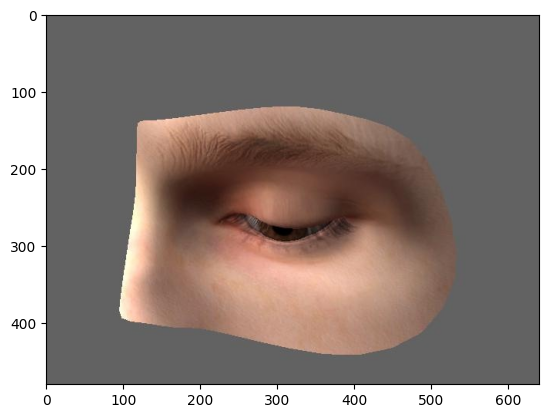

Sample TrainingSet Image: 10065.jpg Class: Closed


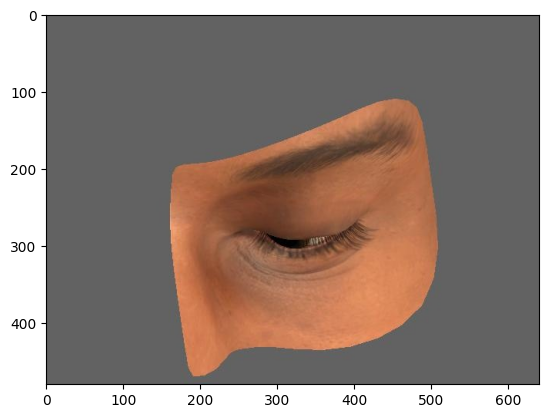

Sample TestSet Image: 10007.jpg Class: Closed


In [5]:
train_data = load_data('./data/TrainingSet/TrainingSet/')

plt.imshow(Image.open(list(train_data.dataset[0])[2]))
plt.show()
print('Sample TrainingSet Image:', os.path.basename(list(train_data.dataset[0])[2]), 'Class:', train_data.dataset.classes[list(train_data.dataset[0])[1]])

test_data = load_data('./data/TestSet/TestSet/')

plt.imshow(Image.open(list(test_data.dataset[0])[2]))
plt.show()
print('Sample TestSet Image:', os.path.basename(list(test_data.dataset[0])[2]), 'Class:', test_data.dataset.classes[list(test_data.dataset[0])[1]])

#### w/o Resnet  Feature Extractor ####

In [6]:
class HybridBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, cardinality, bottleneck_width):
        super(HybridBlock, self).__init__()
        out_channels = cardinality * bottleneck_width
        self.convs = nn.ModuleList()
        for _ in range(cardinality):
            # Each branch within the block
            self.convs.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                # nn.Dropout(0.15),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(inplace=True),
                
                nn.Conv2d(out_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False),
                # nn.Dropout(0.15),
                nn.BatchNorm2d(growth_rate),
                nn.LeakyReLU(inplace=True)
            ))
            in_channels += growth_rate
        
    def forward(self, x):
        out = x
        # print(out.shape)
        for conv in self.convs:
            out = torch.cat([out, conv(out)], 1) # Pass through each branch
            # print(out.shape)
        return out

In [7]:
class HybridDenseNet(nn.Module):
    def __init__(self, growth_rate, cardinality, bottleneck_width, num_classes=10):
        super(HybridDenseNet, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.blocks = nn.ModuleList()
        for _ in range(3):  # 3 layers
            self.blocks.append(self._make_block(growth_rate, cardinality, bottleneck_width))
            self.in_channels += growth_rate * cardinality
        
        self.bn = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, 2)
        
    def _make_block(self, growth_rate, cardinality, bottleneck_width):
        return HybridBlock(self.in_channels, growth_rate, cardinality, bottleneck_width)

    def forward(self, x):
        out = self.conv(x)  # Initial convolutional layer
        for block in self.blocks:  # Pass through each block
            out = block(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)  # Fully connected layer for classification
        return out

In [8]:
class HybridDenseNetLightning(pl.LightningModule):
    def __init__(self, model, l1_ratio = 0.0, l2_ratio = 0.0):
        super().__init__()
        self.model = model  # Your HybridDenseNet model goes here
        self.l1_ratio = l1_ratio
        self.l2_ratio = l2_ratio
        self.train_loss = []
        self.train_acc = []
        self.test_loss = []
        self.test_acc = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y, _ = batch

        logits = self(x.float())
        
        
     
        predicted_classes = torch.softmax(logits, dim = 1).argmax(dim = 1)
        num_correct = (predicted_classes == y).sum()
        acc = float(num_correct/len(y))
        
        y = F.one_hot(y, num_classes = 2)
        loss = F.cross_entropy(logits.float(), y.float())
        
        ##Adding Regulartors
        #L1 regularization
        loss = loss + self.l1_ratio * sum([p.abs().sum() for p in self.model.parameters()])

        #L2 regularization
        loss = loss + self.l2_ratio * sum([(p**2).sum() for p in self.model.parameters()])
        
        if batch_idx % 10 == 9:
            self.train_loss.append(loss.item())
            self.train_acc.append(acc)

        if batch_idx % 50 == 49:
                print('[%5d] loss : %.6f acc: %.6f' %(batch_idx + 1, loss.item(), acc))
        self.log('train_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x.float())
        
        
        predicted_classes = torch.softmax(logits, dim = 1).argmax(dim = 1)
        num_correct = (predicted_classes == y).sum()
        acc = float(num_correct/len(y))
        
        y = F.one_hot(y, num_classes = 2)
        loss = F.cross_entropy(logits.float(), y.float())
        
        self.test_loss.append(loss.item())
        self.test_acc.append(acc)

        if batch_idx % 10 == 9:
                print('[%d] loss : %.6f acc: %.6f' %(batch_idx + 1, loss.item(), acc))
        self.log('test_loss', loss)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay= 1e-6)
        return optimizer

In [ ]:
losses = {}
acc = {}
bottle_necks = [2, 4, 8, 16, 32]
cardinalities = [2, 4, 8]
growth_rates = [2, 4, 8, 16, 32]
for j in cardinalities: 
    for i in bottle_necks:
        for k in growth_rates: 
            try: 
                print("Cardinality: {}, Growth Rate: {}, Bottleneck: {}". format(j, i, k))
                print("=" * 100)
                trainer = pl.Trainer(accelerator = 'gpu', devices = 1, max_epochs = 20)
                net = HybridDenseNet(growth_rate=j, cardinality=k, bottleneck_width=i, num_classes=1)
                lightning_model = HybridDenseNetLightning(net)
                trainer.fit(lightning_model, train_data)
                print("-" * 100)
                print('Testing model..')
                trainer.test(model = lightning_model, dataloaders=test_data)
                losses.update({"C {}, BN: {}, GR: {}".format(j, i, k) : lightning_model.test_loss})
                acc.update({"C {}, BN: {}, GR: {}".format(j, i, k): lightning_model.test_acc})
            except:
                print("Cardinality: {}, Growth Rate: {}, Bottleneck: {}". format(j, i, k))
                print("CUDA ERROR")

Cardinality: 2, Growth Rate: 2, Bottleneck: 2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 11.9 K
-----------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.047     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[   50] loss : 0.695150 acc: 0.406250
[   50] loss : 0.669052 acc: 0.656250
[   50] loss : 0.687990 acc: 0.562500
[   50] loss : 0.683273 acc: 0.593750
[   50] loss : 0.671912 acc: 0.593750
[   50] loss : 0.710070 acc: 0.406250
[   50] loss : 0.686448 acc: 0.625000
[   50] loss : 0.663895 acc: 0.656250
[   50] loss : 0.646080 acc: 0.750000
[   50] loss : 0.654826 acc: 0.656250
[   50] loss : 0.660391 acc: 0.656250
[   50] loss : 0.667830 acc: 0.687500
[   50] loss : 0.650777 acc: 0.656250
[   50] loss : 0.679946 acc: 0.625000
[   50] loss : 0.661374 acc: 0.750000
[   50] loss : 0.643387 acc: 0.718750
[   50] loss : 0.672358 acc: 0.625000
[   50] loss : 0.653415 acc: 0.718750
[   50] loss : 0.639602 acc: 0.750000
[   50] loss : 0.692677 acc: 0.531250


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


[10] loss : 0.639918 acc: 0.781250
[20] loss : 0.673129 acc: 0.625000
[30] loss : 0.706567 acc: 0.562500
[40] loss : 0.675185 acc: 0.562500
[50] loss : 0.663897 acc: 0.656250
[60] loss : 0.656562 acc: 0.562500
[70] loss : 0.649899 acc: 0.656250
[80] loss : 0.708194 acc: 0.531250
[90] loss : 0.623677 acc: 0.781250
[100] loss : 0.653970 acc: 0.687500
[110] loss : 0.608865 acc: 0.843750
[120] loss : 0.649663 acc: 0.750000
[130] loss : 0.682739 acc: 0.562500


/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6560089588165283     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 18.9 K
-----------------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 2, Bottleneck: 4


Training: 0it [00:00, ?it/s]

[   50] loss : 0.683694 acc: 0.531250
[   50] loss : 0.692423 acc: 0.437500
[   50] loss : 0.680353 acc: 0.562500
[   50] loss : 0.694767 acc: 0.562500
[   50] loss : 0.663319 acc: 0.750000
[   50] loss : 0.663038 acc: 0.718750
[   50] loss : 0.659539 acc: 0.625000
[   50] loss : 0.639829 acc: 0.781250
[   50] loss : 0.653964 acc: 0.718750
[   50] loss : 0.653547 acc: 0.687500
[   50] loss : 0.662049 acc: 0.625000
[   50] loss : 0.629589 acc: 0.750000
[   50] loss : 0.673504 acc: 0.656250
[   50] loss : 0.626859 acc: 0.718750
[   50] loss : 0.645374 acc: 0.687500
[   50] loss : 0.633846 acc: 0.656250
[   50] loss : 0.573947 acc: 0.812500
[   50] loss : 0.569004 acc: 0.781250
[   50] loss : 0.611703 acc: 0.781250
[   50] loss : 0.583060 acc: 0.781250


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.596442 acc: 0.750000
[20] loss : 0.590866 acc: 0.750000
[30] loss : 0.644835 acc: 0.687500
[40] loss : 0.581623 acc: 0.812500
[50] loss : 0.652336 acc: 0.656250
[60] loss : 0.626412 acc: 0.687500
[70] loss : 0.620036 acc: 0.656250
[80] loss : 0.659259 acc: 0.531250
[90] loss : 0.638430 acc: 0.687500
[100] loss : 0.585472 acc: 0.812500
[110] loss : 0.602089 acc: 0.718750
[120] loss : 0.605334 acc: 0.812500
[130] loss : 0.619563 acc: 0.625000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6006463170051575     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 51.0 K
-----------------------------------------
51.0 K    Trainable params
0         Non-trainable params
51.0 K    Total params
0.204     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 2, Bottleneck: 8


Training: 0it [00:00, ?it/s]

[   50] loss : 0.693654 acc: 0.500000
[   50] loss : 0.637011 acc: 0.812500
[   50] loss : 0.661511 acc: 0.593750
[   50] loss : 0.615609 acc: 0.781250
[   50] loss : 0.583906 acc: 0.875000
[   50] loss : 0.533115 acc: 0.968750
[   50] loss : 0.583178 acc: 0.750000
[   50] loss : 0.521928 acc: 0.875000
[   50] loss : 0.535332 acc: 0.875000
[   50] loss : 0.468594 acc: 0.937500
[   50] loss : 0.502299 acc: 0.875000
[   50] loss : 0.465633 acc: 0.906250
[   50] loss : 0.395740 acc: 0.937500
[   50] loss : 0.445178 acc: 0.906250
[   50] loss : 0.415129 acc: 0.906250
[   50] loss : 0.364732 acc: 0.937500
[   50] loss : 0.350844 acc: 0.937500
[   50] loss : 0.322005 acc: 0.968750
[   50] loss : 0.361317 acc: 0.875000
[   50] loss : 0.362075 acc: 0.906250


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.494037 acc: 0.781250
[20] loss : 0.495819 acc: 0.687500
[30] loss : 0.573349 acc: 0.718750
[40] loss : 0.479890 acc: 0.781250
[50] loss : 0.440775 acc: 0.843750
[60] loss : 0.430718 acc: 0.812500
[70] loss : 0.427405 acc: 0.843750
[80] loss : 0.535604 acc: 0.750000
[90] loss : 0.487156 acc: 0.812500
[100] loss : 0.398234 acc: 0.812500
[110] loss : 0.384271 acc: 0.843750
[120] loss : 0.470881 acc: 0.781250
[130] loss : 0.552084 acc: 0.687500


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4799484610557556     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 211 K 
-----------------------------------------
211 K     Trainable params
0         Non-trainable params
211 K     Total params
0.846     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 2, Bottleneck: 16


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Cardinality: 2, Growth Rate: 2, Bottleneck: 16
CUDA ERROR
Cardinality: 2, Growth Rate: 2, Bottleneck: 32



  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 1.1 M 
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.442     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 14.0 K
-----------------------------------------
14.0 K    Trainable params
0         Non-trainable params
14.0 K    Total params
0.056     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 2, Bottleneck: 32
CUDA ERROR
Cardinality: 2, Growth Rate: 4, Bottleneck: 2


Training: 0it [00:00, ?it/s]

[   50] loss : 0.691463 acc: 0.500000
[   50] loss : 0.664722 acc: 0.750000
[   50] loss : 0.707250 acc: 0.500000
[   50] loss : 0.655290 acc: 0.812500
[   50] loss : 0.673556 acc: 0.562500
[   50] loss : 0.680865 acc: 0.625000
[   50] loss : 0.661157 acc: 0.625000
[   50] loss : 0.644058 acc: 0.750000
[   50] loss : 0.674343 acc: 0.656250
[   50] loss : 0.657062 acc: 0.750000
[   50] loss : 0.651694 acc: 0.687500
[   50] loss : 0.646130 acc: 0.687500
[   50] loss : 0.644047 acc: 0.718750
[   50] loss : 0.648430 acc: 0.750000
[   50] loss : 0.694271 acc: 0.531250
[   50] loss : 0.625072 acc: 0.718750
[   50] loss : 0.647803 acc: 0.718750
[   50] loss : 0.657017 acc: 0.625000
[   50] loss : 0.645534 acc: 0.718750
[   50] loss : 0.600055 acc: 0.843750


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.668230 acc: 0.656250
[20] loss : 0.605375 acc: 0.750000
[30] loss : 0.659203 acc: 0.718750
[40] loss : 0.578881 acc: 0.781250
[50] loss : 0.661590 acc: 0.625000
[60] loss : 0.658870 acc: 0.562500
[70] loss : 0.646254 acc: 0.718750
[80] loss : 0.651870 acc: 0.687500
[90] loss : 0.592983 acc: 0.718750
[100] loss : 0.632895 acc: 0.781250
[110] loss : 0.616530 acc: 0.656250
[120] loss : 0.654689 acc: 0.625000
[130] loss : 0.669253 acc: 0.687500


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6339969635009766     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 28.1 K
-----------------------------------------
28.1 K    Trainable params
0         Non-trainable params
28.1 K    Total params
0.112     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 4, Bottleneck: 4


Training: 0it [00:00, ?it/s]

[   50] loss : 0.689457 acc: 0.562500
[   50] loss : 0.674250 acc: 0.562500
[   50] loss : 0.668867 acc: 0.593750
[   50] loss : 0.680768 acc: 0.562500
[   50] loss : 0.638967 acc: 0.718750
[   50] loss : 0.662943 acc: 0.656250
[   50] loss : 0.626680 acc: 0.687500
[   50] loss : 0.653373 acc: 0.718750
[   50] loss : 0.661999 acc: 0.625000
[   50] loss : 0.628154 acc: 0.687500
[   50] loss : 0.626772 acc: 0.781250
[   50] loss : 0.623470 acc: 0.781250
[   50] loss : 0.608814 acc: 0.656250
[   50] loss : 0.576690 acc: 0.812500
[   50] loss : 0.655580 acc: 0.687500
[   50] loss : 0.577061 acc: 0.875000
[   50] loss : 0.579290 acc: 0.781250
[   50] loss : 0.536286 acc: 0.843750
[   50] loss : 0.484836 acc: 0.906250
[   50] loss : 0.532097 acc: 0.875000


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.492570 acc: 0.875000
[20] loss : 0.512628 acc: 0.781250
[30] loss : 0.470736 acc: 0.875000
[40] loss : 0.504145 acc: 0.812500
[50] loss : 0.495130 acc: 0.843750
[60] loss : 0.495076 acc: 0.906250
[70] loss : 0.517345 acc: 0.906250
[80] loss : 0.508706 acc: 0.843750
[90] loss : 0.536500 acc: 0.906250
[100] loss : 0.514958 acc: 0.906250
[110] loss : 0.533608 acc: 0.781250
[120] loss : 0.547330 acc: 0.781250
[130] loss : 0.504047 acc: 0.812500


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5151675343513489     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 92.1 K
-----------------------------------------
92.1 K    Trainable params
0         Non-trainable params
92.1 K    Total params
0.369     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 4, Bottleneck: 8


Training: 0it [00:00, ?it/s]

[   50] loss : 0.691001 acc: 0.562500
[   50] loss : 0.626842 acc: 0.750000
[   50] loss : 0.625157 acc: 0.687500
[   50] loss : 0.624177 acc: 0.687500
[   50] loss : 0.609539 acc: 0.781250
[   50] loss : 0.620300 acc: 0.718750
[   50] loss : 0.574468 acc: 0.843750
[   50] loss : 0.527698 acc: 0.843750
[   50] loss : 0.511741 acc: 0.906250
[   50] loss : 0.453932 acc: 0.875000
[   50] loss : 0.414177 acc: 0.968750
[   50] loss : 0.497965 acc: 0.875000
[   50] loss : 0.370758 acc: 0.937500
[   50] loss : 0.360372 acc: 0.968750
[   50] loss : 0.419025 acc: 0.875000
[   50] loss : 0.349449 acc: 0.906250
[   50] loss : 0.404263 acc: 0.843750
[   50] loss : 0.327523 acc: 0.906250
[   50] loss : 0.488874 acc: 0.843750
[   50] loss : 0.413786 acc: 0.781250


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.343576 acc: 0.875000
[20] loss : 0.285520 acc: 0.906250
[30] loss : 0.337386 acc: 0.906250
[40] loss : 0.259049 acc: 0.968750
[50] loss : 0.323292 acc: 0.906250
[60] loss : 0.248587 acc: 0.968750
[70] loss : 0.307006 acc: 0.875000
[80] loss : 0.350207 acc: 0.875000
[90] loss : 0.286661 acc: 0.937500
[100] loss : 0.224640 acc: 0.968750
[110] loss : 0.282818 acc: 0.968750
[120] loss : 0.382894 acc: 0.843750
[130] loss : 0.390754 acc: 0.937500


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.2811066210269928     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Cardinality: 2, Growth Rate: 4, Bottleneck: 16


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 412 K 
-----------------------------------------
412 K     Trainable params
0         Non-trainable params
412 K     Total params
1.651     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Cardinality: 2, Growth Rate: 4, Bottleneck: 16
CUDA ERROR
Cardinality: 2, Growth Rate: 4, Bottleneck: 32



  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 2.2 M 
-----------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.841     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 18.3 K
-----------------------------------------
18.3 K    Trainable params
0         Non-trainable params
18.3 K    Total params
0.073     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 4, Bottleneck: 32
CUDA ERROR
Cardinality: 2, Growth Rate: 8, Bottleneck: 2


Training: 0it [00:00, ?it/s]

[   50] loss : 0.693764 acc: 0.625000
[   50] loss : 0.692251 acc: 0.500000
[   50] loss : 0.670669 acc: 0.656250
[   50] loss : 0.651279 acc: 0.656250
[   50] loss : 0.658656 acc: 0.625000
[   50] loss : 0.661930 acc: 0.718750
[   50] loss : 0.661272 acc: 0.593750
[   50] loss : 0.657549 acc: 0.531250
[   50] loss : 0.684637 acc: 0.500000
[   50] loss : 0.661346 acc: 0.562500
[   50] loss : 0.700115 acc: 0.500000
[   50] loss : 0.628551 acc: 0.718750
[   50] loss : 0.680098 acc: 0.593750
[   50] loss : 0.652066 acc: 0.687500
[   50] loss : 0.676520 acc: 0.531250
[   50] loss : 0.645265 acc: 0.687500
[   50] loss : 0.639084 acc: 0.656250
[   50] loss : 0.645403 acc: 0.656250
[   50] loss : 0.692342 acc: 0.562500
[   50] loss : 0.686504 acc: 0.625000


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.660826 acc: 0.562500
[20] loss : 0.666203 acc: 0.531250
[30] loss : 0.603743 acc: 0.812500
[40] loss : 0.674207 acc: 0.531250
[50] loss : 0.649622 acc: 0.531250
[60] loss : 0.652866 acc: 0.625000
[70] loss : 0.695020 acc: 0.500000
[80] loss : 0.657569 acc: 0.656250
[90] loss : 0.599636 acc: 0.750000
[100] loss : 0.621436 acc: 0.656250
[110] loss : 0.692650 acc: 0.562500
[120] loss : 0.617548 acc: 0.656250
[130] loss : 0.648095 acc: 0.625000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6444441080093384     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 46.3 K
-----------------------------------------
46.3 K    Trainable params
0         Non-trainable params
46.3 K    Total params
0.185     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 8, Bottleneck: 4


Training: 0it [00:00, ?it/s]

[   50] loss : 0.703515 acc: 0.437500
[   50] loss : 0.639110 acc: 0.687500
[   50] loss : 0.634562 acc: 0.750000
[   50] loss : 0.600899 acc: 0.812500
[   50] loss : 0.641812 acc: 0.750000
[   50] loss : 0.604961 acc: 0.718750
[   50] loss : 0.609791 acc: 0.750000
[   50] loss : 0.574710 acc: 0.875000
[   50] loss : 0.572657 acc: 0.812500
[   50] loss : 0.559706 acc: 0.843750
[   50] loss : 0.507854 acc: 0.875000
[   50] loss : 0.544884 acc: 0.875000
[   50] loss : 0.528987 acc: 0.812500
[   50] loss : 0.495669 acc: 0.937500
[   50] loss : 0.479758 acc: 0.875000
[   50] loss : 0.519102 acc: 0.812500
[   50] loss : 0.507762 acc: 0.843750
[   50] loss : 0.452984 acc: 0.843750
[   50] loss : 0.408672 acc: 0.906250
[   50] loss : 0.428282 acc: 0.906250


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.560459 acc: 0.781250
[20] loss : 0.559093 acc: 0.718750
[30] loss : 0.500577 acc: 0.843750
[40] loss : 0.570535 acc: 0.750000
[50] loss : 0.552742 acc: 0.875000
[60] loss : 0.672495 acc: 0.593750
[70] loss : 0.495108 acc: 0.843750
[80] loss : 0.522716 acc: 0.781250
[90] loss : 0.566402 acc: 0.750000
[100] loss : 0.504022 acc: 0.812500
[110] loss : 0.508214 acc: 0.812500
[120] loss : 0.455977 acc: 0.843750
[130] loss : 0.477959 acc: 0.812500


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5346888899803162     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 174 K 
-----------------------------------------
174 K     Trainable params
0         Non-trainable params
174 K     Total params
0.697     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 8, Bottleneck: 8


Training: 0it [00:00, ?it/s]

[   50] loss : 0.670734 acc: 0.656250
[   50] loss : 0.603339 acc: 0.750000
[   50] loss : 0.595740 acc: 0.781250
[   50] loss : 0.573870 acc: 0.875000
[   50] loss : 0.549110 acc: 0.812500
[   50] loss : 0.555238 acc: 0.812500
[   50] loss : 0.515724 acc: 0.906250
[   50] loss : 0.518725 acc: 0.812500
[   50] loss : 0.522642 acc: 0.812500
[   50] loss : 0.450778 acc: 0.906250
[   50] loss : 0.483256 acc: 0.875000
[   50] loss : 0.424557 acc: 0.843750
[   50] loss : 0.417788 acc: 0.875000
[   50] loss : 0.378104 acc: 0.968750
[   50] loss : 0.342820 acc: 0.937500
[   50] loss : 0.369266 acc: 0.968750
[   50] loss : 0.361540 acc: 0.906250
[   50] loss : 0.374756 acc: 0.906250
[   50] loss : 0.408682 acc: 0.875000
[   50] loss : 0.263077 acc: 0.968750


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.440830 acc: 0.812500
[20] loss : 0.468869 acc: 0.781250
[30] loss : 1.161576 acc: 0.687500
[40] loss : 1.060946 acc: 0.718750
[50] loss : 0.846405 acc: 0.718750
[60] loss : 0.452373 acc: 0.781250
[70] loss : 1.395079 acc: 0.781250
[80] loss : 0.968032 acc: 0.656250
[90] loss : 0.684908 acc: 0.656250
[100] loss : 0.518417 acc: 0.750000
[110] loss : 0.844180 acc: 0.781250
[120] loss : 0.926198 acc: 0.625000
[130] loss : 0.482695 acc: 0.812500


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6912131905555725     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 815 K 
-----------------------------------------
815 K     Trainable params
0         Non-trainable params
815 K     Total params
3.260     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 8, Bottleneck: 16


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Cardinality: 2, Growth Rate: 8, Bottleneck: 16
CUDA ERROR
Cardinality: 2, Growth Rate: 8, Bottleneck: 32


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 4.4 M 
-----------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.640    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Cardinality: 2, Growth Rate: 8, Bottleneck: 32
CUDA ERROR
Cardinality: 2, Growth Rate: 16, Bottleneck: 2



  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 26.8 K
-----------------------------------------
26.8 K    Trainable params
0         Non-trainable params
26.8 K    Total params
0.107     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[   50] loss : 0.668528 acc: 0.625000
[   50] loss : 0.685526 acc: 0.531250
[   50] loss : 0.690038 acc: 0.500000
[   50] loss : 0.692392 acc: 0.468750
[   50] loss : 0.662591 acc: 0.656250
[   50] loss : 0.635685 acc: 0.750000
[   50] loss : 0.625530 acc: 0.656250
[   50] loss : 0.653251 acc: 0.687500
[   50] loss : 0.620777 acc: 0.875000
[   50] loss : 0.654598 acc: 0.625000
[   50] loss : 0.624636 acc: 0.812500
[   50] loss : 0.619564 acc: 0.781250
[   50] loss : 0.645955 acc: 0.687500
[   50] loss : 0.577386 acc: 0.937500
[   50] loss : 0.612517 acc: 0.718750
[   50] loss : 0.609650 acc: 0.812500
[   50] loss : 0.655129 acc: 0.781250
[   50] loss : 0.618208 acc: 0.656250
[   50] loss : 0.621328 acc: 0.718750
[   50] loss : 0.580193 acc: 0.906250


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.616800 acc: 0.718750
[20] loss : 0.609980 acc: 0.781250
[30] loss : 0.632175 acc: 0.687500
[40] loss : 0.593086 acc: 0.750000
[50] loss : 0.592218 acc: 0.687500
[60] loss : 0.557630 acc: 0.906250
[70] loss : 0.607806 acc: 0.843750
[80] loss : 0.595039 acc: 0.781250
[90] loss : 0.567062 acc: 0.812500
[100] loss : 0.662538 acc: 0.750000
[110] loss : 0.587626 acc: 0.781250
[120] loss : 0.610851 acc: 0.812500
[130] loss : 0.626114 acc: 0.812500


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6029154658317566     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 82.8 K
-----------------------------------------
82.8 K    Trainable params
0         Non-trainable params
82.8 K    Total params
0.331     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 16, Bottleneck: 4


Training: 0it [00:00, ?it/s]

[   50] loss : 0.696907 acc: 0.437500
[   50] loss : 0.671965 acc: 0.562500
[   50] loss : 0.632841 acc: 0.750000
[   50] loss : 0.628913 acc: 0.750000
[   50] loss : 0.638068 acc: 0.750000
[   50] loss : 0.613619 acc: 0.781250
[   50] loss : 0.587155 acc: 0.812500
[   50] loss : 0.555019 acc: 0.812500
[   50] loss : 0.568390 acc: 0.843750
[   50] loss : 0.559116 acc: 0.843750
[   50] loss : 0.543731 acc: 0.875000
[   50] loss : 0.571109 acc: 0.812500
[   50] loss : 0.524641 acc: 0.937500
[   50] loss : 0.555739 acc: 0.812500
[   50] loss : 0.523239 acc: 0.843750
[   50] loss : 0.553326 acc: 0.781250
[   50] loss : 0.465254 acc: 0.937500
[   50] loss : 0.507365 acc: 0.812500
[   50] loss : 0.441732 acc: 0.968750
[   50] loss : 0.476358 acc: 0.937500


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.527383 acc: 0.718750
[20] loss : 0.479742 acc: 0.843750
[30] loss : 0.532940 acc: 0.687500
[40] loss : 0.487716 acc: 0.781250
[50] loss : 0.466453 acc: 0.843750
[60] loss : 0.469589 acc: 0.875000
[70] loss : 0.500120 acc: 0.875000
[80] loss : 0.487802 acc: 0.843750
[90] loss : 0.530556 acc: 0.687500
[100] loss : 0.470132 acc: 0.875000
[110] loss : 0.507355 acc: 0.812500
[120] loss : 0.454359 acc: 0.906250
[130] loss : 0.500021 acc: 0.812500


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4960959553718567     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 338 K 
-----------------------------------------
338 K     Trainable params
0         Non-trainable params
338 K     Total params
1.355     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 16, Bottleneck: 8


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Cardinality: 2, Growth Rate: 16, Bottleneck: 8
CUDA ERROR
Cardinality: 2, Growth Rate: 16, Bottleneck: 16



  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 1.6 M 
-----------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.480     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Cardinality: 2, Growth Rate: 16, Bottleneck: 16
CUDA ERROR
Cardinality: 2, Growth Rate: 16, Bottleneck: 32


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 8.8 M 
-----------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.236    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 43.9 K
-----------------------------------------
43.9 K    Trainable params
0         Non-trainable params
43.9 K    Total params
0.176     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 16, Bottleneck: 32
CUDA ERROR
Cardinality: 2, Growth Rate: 32, Bottleneck: 2


Training: 0it [00:00, ?it/s]

[   50] loss : 0.690963 acc: 0.500000
[   50] loss : 0.687009 acc: 0.500000
[   50] loss : 0.649897 acc: 0.687500
[   50] loss : 0.688510 acc: 0.562500
[   50] loss : 0.702530 acc: 0.593750
[   50] loss : 0.648541 acc: 0.687500
[   50] loss : 0.664844 acc: 0.562500
[   50] loss : 0.615556 acc: 0.812500
[   50] loss : 0.692897 acc: 0.656250
[   50] loss : 0.650321 acc: 0.562500
[   50] loss : 0.621691 acc: 0.812500
[   50] loss : 0.636387 acc: 0.656250
[   50] loss : 0.604560 acc: 0.781250
[   50] loss : 0.625896 acc: 0.750000
[   50] loss : 0.637370 acc: 0.656250
[   50] loss : 0.600016 acc: 0.812500
[   50] loss : 0.592988 acc: 0.937500
[   50] loss : 0.615106 acc: 0.718750
[   50] loss : 0.619885 acc: 0.718750
[   50] loss : 0.620369 acc: 0.781250


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.578762 acc: 0.812500
[20] loss : 0.572777 acc: 0.843750
[30] loss : 0.613738 acc: 0.750000
[40] loss : 0.579721 acc: 0.875000
[50] loss : 0.584023 acc: 0.812500
[60] loss : 0.613385 acc: 0.718750
[70] loss : 0.616235 acc: 0.781250
[80] loss : 0.595121 acc: 0.781250
[90] loss : 0.507373 acc: 0.906250
[100] loss : 0.569359 acc: 0.812500
[110] loss : 0.574848 acc: 0.781250
[120] loss : 0.576570 acc: 0.812500
[130] loss : 0.594429 acc: 0.718750


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5838520526885986     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 155 K 
-----------------------------------------
155 K     Trainable params
0         Non-trainable params
155 K     Total params
0.623     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 32, Bottleneck: 4


Training: 0it [00:00, ?it/s]

[   50] loss : 0.686709 acc: 0.625000
[   50] loss : 0.635376 acc: 0.687500
[   50] loss : 0.651948 acc: 0.625000
[   50] loss : 0.639018 acc: 0.750000
[   50] loss : 0.660418 acc: 0.593750
[   50] loss : 0.636063 acc: 0.750000
[   50] loss : 0.639094 acc: 0.562500
[   50] loss : 0.638644 acc: 0.687500
[   50] loss : 0.615901 acc: 0.750000
[   50] loss : 0.622195 acc: 0.718750
[   50] loss : 0.537106 acc: 0.875000
[   50] loss : 0.571547 acc: 0.750000
[   50] loss : 0.629554 acc: 0.750000
[   50] loss : 0.522601 acc: 0.843750
[   50] loss : 0.571339 acc: 0.812500
[   50] loss : 0.532537 acc: 0.843750
[   50] loss : 0.456261 acc: 0.906250
[   50] loss : 0.493416 acc: 0.812500
[   50] loss : 0.425645 acc: 0.968750
[   50] loss : 0.570210 acc: 0.781250


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.513069 acc: 0.843750
[20] loss : 0.484793 acc: 0.843750
[30] loss : 0.411126 acc: 0.937500
[40] loss : 0.551171 acc: 0.718750
[50] loss : 0.486750 acc: 0.812500
[60] loss : 0.515294 acc: 0.843750
[70] loss : 0.635777 acc: 0.625000
[80] loss : 0.544930 acc: 0.781250
[90] loss : 0.562493 acc: 0.718750
[100] loss : 0.480764 acc: 0.781250
[110] loss : 0.554252 acc: 0.781250
[120] loss : 0.455876 acc: 0.875000
[130] loss : 0.520070 acc: 0.750000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5247474312782288     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 667 K 
-----------------------------------------
667 K     Trainable params
0         Non-trainable params
667 K     Total params
2.669     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 32, Bottleneck: 8


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Cardinality: 2, Growth Rate: 32, Bottleneck: 8
CUDA ERROR
Cardinality: 2, Growth Rate: 32, Bottleneck: 16



  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 3.2 M 
-----------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.919    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Cardinality: 2, Growth Rate: 32, Bottleneck: 16
CUDA ERROR
Cardinality: 2, Growth Rate: 32, Bottleneck: 32


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 17.6 M
-----------------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params
70.429    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 12.5 K
-----------------------------------------
12.5 K    Trainable params
0         Non-trainable params
12.5 K    Total params
0.050     Total estimated model params size (MB)


Cardinality: 2, Growth Rate: 32, Bottleneck: 32
CUDA ERROR
Cardinality: 4, Growth Rate: 2, Bottleneck: 2


Training: 0it [00:00, ?it/s]

[   50] loss : 0.701224 acc: 0.437500
[   50] loss : 0.699003 acc: 0.437500
[   50] loss : 0.680166 acc: 0.562500
[   50] loss : 0.665705 acc: 0.687500
[   50] loss : 0.692399 acc: 0.562500
[   50] loss : 0.672618 acc: 0.625000
[   50] loss : 0.656986 acc: 0.656250
[   50] loss : 0.695360 acc: 0.562500
[   50] loss : 0.696884 acc: 0.593750
[   50] loss : 0.662685 acc: 0.656250
[   50] loss : 0.665928 acc: 0.656250
[   50] loss : 0.710390 acc: 0.562500
[   50] loss : 0.669778 acc: 0.593750
[   50] loss : 0.657031 acc: 0.687500
[   50] loss : 0.677997 acc: 0.562500
[   50] loss : 0.634113 acc: 0.718750
[   50] loss : 0.654276 acc: 0.781250
[   50] loss : 0.676480 acc: 0.625000
[   50] loss : 0.649520 acc: 0.687500
[   50] loss : 0.655320 acc: 0.687500


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.676286 acc: 0.625000
[20] loss : 0.698158 acc: 0.562500
[30] loss : 0.677277 acc: 0.531250
[40] loss : 0.644488 acc: 0.625000
[50] loss : 0.689735 acc: 0.531250
[60] loss : 0.664771 acc: 0.593750
[70] loss : 0.670003 acc: 0.562500
[80] loss : 0.631219 acc: 0.656250
[90] loss : 0.622282 acc: 0.781250
[100] loss : 0.651959 acc: 0.656250
[110] loss : 0.664317 acc: 0.687500
[120] loss : 0.645394 acc: 0.718750
[130] loss : 0.694040 acc: 0.531250


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6646503210067749     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 21.9 K
-----------------------------------------
21.9 K    Trainable params
0         Non-trainable params
21.9 K    Total params
0.087     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 2, Bottleneck: 4


Training: 0it [00:00, ?it/s]

[   50] loss : 0.682959 acc: 0.531250
[   50] loss : 0.680269 acc: 0.593750
[   50] loss : 0.654889 acc: 0.625000
[   50] loss : 0.638367 acc: 0.750000
[   50] loss : 0.614810 acc: 0.781250
[   50] loss : 0.637469 acc: 0.750000
[   50] loss : 0.611192 acc: 0.812500
[   50] loss : 0.575983 acc: 0.843750
[   50] loss : 0.614140 acc: 0.750000
[   50] loss : 0.597885 acc: 0.687500
[   50] loss : 0.645440 acc: 0.718750
[   50] loss : 0.631992 acc: 0.687500
[   50] loss : 0.562952 acc: 0.812500
[   50] loss : 0.589316 acc: 0.718750
[   50] loss : 0.463642 acc: 0.937500
[   50] loss : 0.530391 acc: 0.843750
[   50] loss : 0.546030 acc: 0.781250
[   50] loss : 0.512173 acc: 0.875000
[   50] loss : 0.550113 acc: 0.843750
[   50] loss : 0.517317 acc: 0.843750


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.486187 acc: 0.843750
[20] loss : 0.521744 acc: 0.750000
[30] loss : 0.509311 acc: 0.781250
[40] loss : 0.501710 acc: 0.812500
[50] loss : 0.574303 acc: 0.687500
[60] loss : 0.529691 acc: 0.812500
[70] loss : 0.500532 acc: 0.812500
[80] loss : 0.532118 acc: 0.781250
[90] loss : 0.549364 acc: 0.687500
[100] loss : 0.487669 acc: 0.875000
[110] loss : 0.434295 acc: 0.937500
[120] loss : 0.528977 acc: 0.781250
[130] loss : 0.534933 acc: 0.781250


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5104533433914185     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 67.1 K
-----------------------------------------
67.1 K    Trainable params
0         Non-trainable params
67.1 K    Total params
0.268     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 2, Bottleneck: 8


Training: 0it [00:00, ?it/s]

[   50] loss : 0.690503 acc: 0.406250
[   50] loss : 0.648320 acc: 0.750000
[   50] loss : 0.625347 acc: 0.718750
[   50] loss : 0.587915 acc: 0.812500
[   50] loss : 0.667924 acc: 0.718750
[   50] loss : 0.528203 acc: 0.906250
[   50] loss : 0.496644 acc: 0.875000
[   50] loss : 0.496151 acc: 0.875000
[   50] loss : 0.420970 acc: 0.968750
[   50] loss : 0.391964 acc: 1.000000
[   50] loss : 0.384401 acc: 0.937500
[   50] loss : 0.395714 acc: 0.906250
[   50] loss : 0.349336 acc: 0.906250
[   50] loss : 0.343886 acc: 0.906250
[   50] loss : 0.283746 acc: 1.000000
[   50] loss : 0.279867 acc: 0.937500
[   50] loss : 0.292395 acc: 0.906250
[   50] loss : 0.311906 acc: 0.937500
[   50] loss : 0.239473 acc: 0.937500
[   50] loss : 0.285851 acc: 0.937500


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.343500 acc: 0.875000
[20] loss : 0.337972 acc: 0.906250
[30] loss : 0.330106 acc: 0.843750
[40] loss : 0.311223 acc: 0.906250
[50] loss : 0.269754 acc: 0.937500
[60] loss : 0.384975 acc: 0.843750
[70] loss : 0.359814 acc: 0.906250
[80] loss : 0.287918 acc: 0.875000
[90] loss : 0.273709 acc: 0.937500
[100] loss : 0.323896 acc: 0.875000
[110] loss : 0.314691 acc: 0.843750
[120] loss : 0.312212 acc: 0.843750
[130] loss : 0.306322 acc: 0.906250


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.2929482161998749     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 311 K 
-----------------------------------------
311 K     Trainable params
0         Non-trainable params
311 K     Total params
1.247     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 2, Bottleneck: 16


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Cardinality: 4, Growth Rate: 2, Bottleneck: 16
CUDA ERROR
Cardinality: 4, Growth Rate: 2, Bottleneck: 32


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 1.8 M 
-----------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.224     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 15.2 K
-----------------------------------------
15.2 K    Trainable params
0         Non-trainable params
15.2 K    Total params
0.061     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 2, Bottleneck: 32
CUDA ERROR
Cardinality: 4, Growth Rate: 4, Bottleneck: 2


Training: 0it [00:00, ?it/s]

[   50] loss : 0.695813 acc: 0.531250
[   50] loss : 0.659844 acc: 0.718750
[   50] loss : 0.658308 acc: 0.718750
[   50] loss : 0.663640 acc: 0.625000
[   50] loss : 0.702122 acc: 0.437500
[   50] loss : 0.671279 acc: 0.625000
[   50] loss : 0.663144 acc: 0.625000
[   50] loss : 0.645878 acc: 0.781250
[   50] loss : 0.650813 acc: 0.687500
[   50] loss : 0.634745 acc: 0.750000
[   50] loss : 0.648313 acc: 0.687500
[   50] loss : 0.585271 acc: 0.812500
[   50] loss : 0.639467 acc: 0.687500
[   50] loss : 0.610292 acc: 0.750000
[   50] loss : 0.598735 acc: 0.843750
[   50] loss : 0.575080 acc: 0.812500
[   50] loss : 0.528005 acc: 0.875000
[   50] loss : 0.533495 acc: 0.906250
[   50] loss : 0.578601 acc: 0.812500
[   50] loss : 0.567817 acc: 0.812500


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.609188 acc: 0.781250
[20] loss : 0.555664 acc: 0.875000
[30] loss : 0.593661 acc: 0.718750
[40] loss : 0.587174 acc: 0.812500
[50] loss : 0.604329 acc: 0.812500
[60] loss : 0.626363 acc: 0.718750
[70] loss : 0.594686 acc: 0.843750
[80] loss : 0.597552 acc: 0.750000
[90] loss : 0.499286 acc: 0.875000
[100] loss : 0.581121 acc: 0.812500
[110] loss : 0.590039 acc: 0.812500
[120] loss : 0.509904 acc: 0.875000
[130] loss : 0.690004 acc: 0.593750


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5877138376235962     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 33.8 K
-----------------------------------------
33.8 K    Trainable params
0         Non-trainable params
33.8 K    Total params
0.135     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 4, Bottleneck: 4


Training: 0it [00:00, ?it/s]

[   50] loss : 0.659669 acc: 0.593750
[   50] loss : 0.678360 acc: 0.625000
[   50] loss : 0.677510 acc: 0.687500
[   50] loss : 0.595030 acc: 0.812500
[   50] loss : 0.623070 acc: 0.750000
[   50] loss : 0.625996 acc: 0.687500
[   50] loss : 0.612202 acc: 0.750000
[   50] loss : 0.569493 acc: 0.843750
[   50] loss : 0.537223 acc: 0.906250
[   50] loss : 0.575923 acc: 0.812500
[   50] loss : 0.539489 acc: 0.937500
[   50] loss : 0.519828 acc: 0.875000
[   50] loss : 0.581008 acc: 0.812500
[   50] loss : 0.480270 acc: 0.906250
[   50] loss : 0.534931 acc: 0.843750
[   50] loss : 0.482824 acc: 0.906250
[   50] loss : 0.503338 acc: 0.812500
[   50] loss : 0.428371 acc: 0.875000
[   50] loss : 0.427299 acc: 0.906250
[   50] loss : 0.388444 acc: 0.968750


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.450935 acc: 0.906250
[20] loss : 0.476582 acc: 0.843750
[30] loss : 0.391391 acc: 0.906250
[40] loss : 0.461390 acc: 0.812500
[50] loss : 0.336901 acc: 1.000000
[60] loss : 0.384104 acc: 0.937500
[70] loss : 0.421540 acc: 0.843750
[80] loss : 0.369692 acc: 0.968750
[90] loss : 0.377012 acc: 0.937500
[100] loss : 0.420084 acc: 0.843750
[110] loss : 0.453730 acc: 0.812500
[120] loss : 0.471318 acc: 0.781250
[130] loss : 0.400159 acc: 0.968750


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.42230406403541565    │
└───────────────────────────┴───────────────────────────┘

Cardinality: 4, Growth Rate: 4, Bottleneck: 8


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 123 K 
-----------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.496     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[   50] loss : 0.669390 acc: 0.562500
[   50] loss : 0.655686 acc: 0.531250
[   50] loss : 0.636793 acc: 0.750000
[   50] loss : 0.570831 acc: 0.781250
[   50] loss : 0.568812 acc: 0.812500
[   50] loss : 0.523971 acc: 0.906250
[   50] loss : 0.472135 acc: 0.875000
[   50] loss : 0.447062 acc: 0.906250
[   50] loss : 0.468149 acc: 0.843750
[   50] loss : 0.476613 acc: 0.781250
[   50] loss : 0.392854 acc: 0.906250
[   50] loss : 0.352944 acc: 0.906250
[   50] loss : 0.326640 acc: 0.906250
[   50] loss : 0.348942 acc: 0.906250
[   50] loss : 0.322951 acc: 0.843750
[   50] loss : 0.300523 acc: 0.875000
[   50] loss : 0.283286 acc: 0.843750
[   50] loss : 0.240239 acc: 0.937500
[   50] loss : 0.315601 acc: 0.937500
[   50] loss : 0.198970 acc: 0.937500


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.280237 acc: 0.906250
[20] loss : 0.551266 acc: 0.781250
[30] loss : 0.327794 acc: 0.875000
[40] loss : 0.420743 acc: 0.843750
[50] loss : 0.431829 acc: 0.812500
[60] loss : 0.338555 acc: 0.875000
[70] loss : 0.206176 acc: 0.968750
[80] loss : 0.243870 acc: 0.937500
[90] loss : 0.548227 acc: 0.781250
[100] loss : 0.281079 acc: 0.937500
[110] loss : 0.502574 acc: 0.781250
[120] loss : 0.443664 acc: 0.843750
[130] loss : 0.414402 acc: 0.812500


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.38525155186653137    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 612 K 
-----------------------------------------
612 K     Trainable params
0         Non-trainable params
612 K     Total params
2.452     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 4, Bottleneck: 16


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Cardinality: 4, Growth Rate: 4, Bottleneck: 16
CUDA ERROR
Cardinality: 4, Growth Rate: 4, Bottleneck: 32


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 3.6 M 
-----------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.400    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Cardinality: 4, Growth Rate: 4, Bottleneck: 32
CUDA ERROR
Cardinality: 4, Growth Rate: 8, Bottleneck: 2



  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 20.6 K
-----------------------------------------
20.6 K    Trainable params
0         Non-trainable params
20.6 K    Total params
0.082     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[   50] loss : 0.701248 acc: 0.468750
[   50] loss : 0.694010 acc: 0.468750
[   50] loss : 0.699627 acc: 0.593750
[   50] loss : 0.663530 acc: 0.656250
[   50] loss : 0.672941 acc: 0.593750
[   50] loss : 0.614608 acc: 0.750000
[   50] loss : 0.656413 acc: 0.718750
[   50] loss : 0.615762 acc: 0.843750
[   50] loss : 0.601609 acc: 0.812500
[   50] loss : 0.651630 acc: 0.718750
[   50] loss : 0.632277 acc: 0.781250
[   50] loss : 0.623906 acc: 0.750000
[   50] loss : 0.603506 acc: 0.750000
[   50] loss : 0.587888 acc: 0.906250
[   50] loss : 0.582972 acc: 0.812500
[   50] loss : 0.579990 acc: 0.750000
[   50] loss : 0.614151 acc: 0.781250
[   50] loss : 0.530707 acc: 0.906250
[   50] loss : 0.556485 acc: 0.875000
[   50] loss : 0.598900 acc: 0.781250


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.608835 acc: 0.781250
[20] loss : 0.709387 acc: 0.687500
[30] loss : 0.572626 acc: 0.781250
[40] loss : 0.606128 acc: 0.750000
[50] loss : 0.519722 acc: 0.718750
[60] loss : 0.620599 acc: 0.656250
[70] loss : 0.624066 acc: 0.500000
[80] loss : 0.580353 acc: 0.750000
[90] loss : 0.753296 acc: 0.625000
[100] loss : 0.681370 acc: 0.593750
[110] loss : 0.616540 acc: 0.687500
[120] loss : 0.622780 acc: 0.656250
[130] loss : 0.553643 acc: 0.781250


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6396410465240479     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 57.6 K
-----------------------------------------
57.6 K    Trainable params
0         Non-trainable params
57.6 K    Total params
0.230     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 8, Bottleneck: 4


Training: 0it [00:00, ?it/s]

[   50] loss : 0.672584 acc: 0.500000
[   50] loss : 0.651766 acc: 0.593750
[   50] loss : 0.640643 acc: 0.750000
[   50] loss : 0.628957 acc: 0.687500
[   50] loss : 0.606482 acc: 0.843750
[   50] loss : 0.608480 acc: 0.781250
[   50] loss : 0.584599 acc: 0.843750
[   50] loss : 0.597206 acc: 0.750000
[   50] loss : 0.533104 acc: 0.843750
[   50] loss : 0.604160 acc: 0.750000
[   50] loss : 0.536361 acc: 0.843750
[   50] loss : 0.571741 acc: 0.718750
[   50] loss : 0.467078 acc: 0.906250
[   50] loss : 0.485064 acc: 0.875000
[   50] loss : 0.580308 acc: 0.781250
[   50] loss : 0.447145 acc: 0.906250
[   50] loss : 0.454167 acc: 0.875000
[   50] loss : 0.446614 acc: 0.875000
[   50] loss : 0.397196 acc: 0.875000
[   50] loss : 0.490917 acc: 0.812500


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.614394 acc: 0.750000
[20] loss : 0.451132 acc: 0.812500
[30] loss : 0.508888 acc: 0.781250
[40] loss : 0.481836 acc: 0.812500
[50] loss : 0.346851 acc: 0.968750
[60] loss : 0.376206 acc: 0.937500
[70] loss : 0.547919 acc: 0.750000
[80] loss : 0.501442 acc: 0.812500
[90] loss : 0.453439 acc: 0.875000
[100] loss : 0.377071 acc: 0.937500
[110] loss : 0.506348 acc: 0.812500
[120] loss : 0.445169 acc: 0.875000
[130] loss : 0.533211 acc: 0.781250


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4795796573162079     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 237 K 
-----------------------------------------
237 K     Trainable params
0         Non-trainable params
237 K     Total params
0.950     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 8, Bottleneck: 8


Training: 0it [00:00, ?it/s]

[   50] loss : 0.657576 acc: 0.687500
[   50] loss : 0.613246 acc: 0.750000
[   50] loss : 0.556902 acc: 0.843750
[   50] loss : 0.532520 acc: 0.812500
[   50] loss : 0.469241 acc: 0.906250
[   50] loss : 0.442217 acc: 0.968750
[   50] loss : 0.423767 acc: 0.937500
[   50] loss : 0.413293 acc: 0.843750
[   50] loss : 0.417290 acc: 0.875000
[   50] loss : 0.404652 acc: 0.843750
[   50] loss : 0.245247 acc: 1.000000
[   50] loss : 0.279178 acc: 1.000000
[   50] loss : 0.345558 acc: 0.875000
[   50] loss : 0.259245 acc: 0.937500
[   50] loss : 0.231425 acc: 0.968750
[   50] loss : 0.180313 acc: 1.000000
[   50] loss : 0.298845 acc: 0.937500
[   50] loss : 0.282192 acc: 0.906250
[   50] loss : 0.189893 acc: 0.937500
[   50] loss : 0.258731 acc: 0.875000


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.359328 acc: 0.875000
[20] loss : 0.181445 acc: 1.000000
[30] loss : 0.199224 acc: 0.937500
[40] loss : 0.215509 acc: 0.937500
[50] loss : 0.604024 acc: 0.968750
[60] loss : 0.210071 acc: 0.968750
[70] loss : 0.173814 acc: 1.000000
[80] loss : 0.223300 acc: 0.875000
[90] loss : 0.232721 acc: 0.937500
[100] loss : 0.263807 acc: 0.906250
[110] loss : 0.250046 acc: 0.937500
[120] loss : 0.204836 acc: 0.906250
[130] loss : 0.219762 acc: 0.937500


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.22751034796237946    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 1.2 M 
-----------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.860     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 8, Bottleneck: 16


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Cardinality: 4, Growth Rate: 8, Bottleneck: 16
CUDA ERROR
Cardinality: 4, Growth Rate: 8, Bottleneck: 32


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 7.2 M 
-----------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.753    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Cardinality: 4, Growth Rate: 8, Bottleneck: 32
CUDA ERROR
Cardinality: 4, Growth Rate: 16, Bottleneck: 2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 31.3 K
-----------------------------------------
31.3 K    Trainable params
0         Non-trainable params
31.3 K    Total params
0.125     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[   50] loss : 0.684205 acc: 0.562500
[   50] loss : 0.639709 acc: 0.781250
[   50] loss : 0.661169 acc: 0.656250
[   50] loss : 0.657271 acc: 0.656250
[   50] loss : 0.629421 acc: 0.812500
[   50] loss : 0.628941 acc: 0.750000
[   50] loss : 0.598465 acc: 0.906250
[   50] loss : 0.629440 acc: 0.781250
[   50] loss : 0.602660 acc: 0.875000
[   50] loss : 0.603939 acc: 0.781250
[   50] loss : 0.587675 acc: 0.843750
[   50] loss : 0.578341 acc: 0.906250
[   50] loss : 0.609905 acc: 0.750000
[   50] loss : 0.549648 acc: 0.906250
[   50] loss : 0.540288 acc: 0.937500
[   50] loss : 0.531949 acc: 0.937500
[   50] loss : 0.544998 acc: 0.906250
[   50] loss : 0.533059 acc: 0.937500
[   50] loss : 0.579867 acc: 0.750000
[   50] loss : 0.452817 acc: 0.906250


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.689284 acc: 0.750000
[20] loss : 0.494700 acc: 0.906250
[30] loss : 0.550548 acc: 0.812500
[40] loss : 0.540147 acc: 0.843750
[50] loss : 0.564736 acc: 0.812500
[60] loss : 0.488008 acc: 0.843750
[70] loss : 0.529796 acc: 0.843750
[80] loss : 0.504375 acc: 0.843750
[90] loss : 0.525418 acc: 0.875000
[100] loss : 0.602136 acc: 0.750000
[110] loss : 0.568795 acc: 0.875000
[120] loss : 0.481964 acc: 0.875000
[130] loss : 0.525096 acc: 0.843750


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5540746450424194     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 105 K 
-----------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.421     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 16, Bottleneck: 4


Training: 0it [00:00, ?it/s]

[   50] loss : 0.710600 acc: 0.375000
[   50] loss : 0.632098 acc: 0.812500
[   50] loss : 0.606897 acc: 0.781250
[   50] loss : 0.593110 acc: 0.875000
[   50] loss : 0.656947 acc: 0.781250
[   50] loss : 0.562722 acc: 0.875000
[   50] loss : 0.513235 acc: 0.875000
[   50] loss : 0.504902 acc: 0.875000
[   50] loss : 0.517323 acc: 0.843750
[   50] loss : 0.501572 acc: 0.875000
[   50] loss : 0.424851 acc: 0.937500
[   50] loss : 0.446736 acc: 0.906250
[   50] loss : 0.442277 acc: 0.875000
[   50] loss : 0.409088 acc: 0.875000
[   50] loss : 0.407821 acc: 0.968750
[   50] loss : 0.480326 acc: 0.781250
[   50] loss : 0.358579 acc: 0.875000
[   50] loss : 0.347744 acc: 0.906250
[   50] loss : 0.401185 acc: 0.875000
[   50] loss : 0.311479 acc: 0.906250


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.316649 acc: 0.968750
[20] loss : 0.308001 acc: 0.875000
[30] loss : 0.322272 acc: 0.937500
[40] loss : 0.344519 acc: 0.875000
[50] loss : 0.324448 acc: 0.875000
[60] loss : 0.291709 acc: 0.968750
[70] loss : 0.334710 acc: 0.906250
[80] loss : 0.400572 acc: 0.812500
[90] loss : 0.375385 acc: 0.875000
[100] loss : 0.367661 acc: 0.875000
[110] loss : 0.327038 acc: 0.906250
[120] loss : 0.342457 acc: 0.906250
[130] loss : 0.432121 acc: 0.781250


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3357180953025818     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 464 K 
-----------------------------------------
464 K     Trainable params
0         Non-trainable params
464 K     Total params
1.860     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 16, Bottleneck: 8


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Cardinality: 4, Growth Rate: 16, Bottleneck: 8
CUDA ERROR
Cardinality: 4, Growth Rate: 16, Bottleneck: 16


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 2.4 M 
-----------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.677     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Cardinality: 4, Growth Rate: 16, Bottleneck: 16
CUDA ERROR
Cardinality: 4, Growth Rate: 16, Bottleneck: 32


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 14.4 M
-----------------------------------------
14.4 M    Trainable params
0         Non-trainable params
14.4 M    Total params
57.457    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 52.8 K
-----------------------------------------
52.8 K    Trainable params
0         Non-trainable params
52.8 K    Total params
0.211     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 16, Bottleneck: 32
CUDA ERROR
Cardinality: 4, Growth Rate: 32, Bottleneck: 2


Training: 0it [00:00, ?it/s]

[   50] loss : 0.687347 acc: 0.562500
[   50] loss : 0.698705 acc: 0.406250
[   50] loss : 0.656076 acc: 0.625000
[   50] loss : 0.662035 acc: 0.562500
[   50] loss : 0.630119 acc: 0.750000
[   50] loss : 0.645142 acc: 0.656250
[   50] loss : 0.629630 acc: 0.781250
[   50] loss : 0.650755 acc: 0.562500
[   50] loss : 0.613393 acc: 0.750000
[   50] loss : 0.602019 acc: 0.750000
[   50] loss : 0.591679 acc: 0.812500
[   50] loss : 0.561990 acc: 0.875000
[   50] loss : 0.608577 acc: 0.750000
[   50] loss : 0.561950 acc: 0.781250
[   50] loss : 0.593051 acc: 0.750000
[   50] loss : 0.518572 acc: 0.906250
[   50] loss : 0.467433 acc: 0.906250
[   50] loss : 0.499293 acc: 0.937500
[   50] loss : 0.503193 acc: 0.906250
[   50] loss : 0.502437 acc: 0.843750


`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


----------------------------------------------------------------------------------------------------
Testing model..


Testing: 0it [00:00, ?it/s]

[10] loss : 0.533197 acc: 0.812500
[20] loss : 0.547346 acc: 0.812500
[30] loss : 0.510375 acc: 0.875000
[40] loss : 0.508798 acc: 0.875000
[50] loss : 0.526667 acc: 0.875000
[60] loss : 0.497724 acc: 0.906250
[70] loss : 0.515798 acc: 0.906250
[80] loss : 0.478639 acc: 0.906250
[90] loss : 0.508385 acc: 0.875000
[100] loss : 0.529200 acc: 0.906250
[110] loss : 0.497450 acc: 0.812500
[120] loss : 0.518938 acc: 0.718750
[130] loss : 0.546348 acc: 0.812500


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.522686779499054     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 200 K 
-----------------------------------------
200 K     Trainable params
0         Non-trainable params
200 K     Total params
0.802     Total estimated model params size (MB)


Cardinality: 4, Growth Rate: 32, Bottleneck: 4


Training: 0it [00:00, ?it/s]

[   50] loss : 0.613957 acc: 0.656250
[   50] loss : 0.601733 acc: 0.781250
[   50] loss : 0.581548 acc: 0.843750
[   50] loss : 0.565598 acc: 0.750000
[   50] loss : 0.584341 acc: 0.718750
[   50] loss : 0.566864 acc: 0.812500
[   50] loss : 0.513897 acc: 0.937500
[   50] loss : 0.498600 acc: 0.843750
[   50] loss : 0.436576 acc: 0.937500
[   50] loss : 0.450048 acc: 0.937500
[   50] loss : 0.453058 acc: 0.937500
[   50] loss : 0.425704 acc: 0.937500
[   50] loss : 0.439415 acc: 0.843750
[   50] loss : 0.397268 acc: 0.875000
[   50] loss : 0.351607 acc: 0.937500
[   50] loss : 0.374035 acc: 0.875000
[   50] loss : 0.326450 acc: 0.937500
[   50] loss : 0.366819 acc: 0.937500
[   50] loss : 0.304984 acc: 0.937500


In [ ]:
loss = pd.DataFrame(losses)
sns.set(rc={'figure.figsize':(90,4)})
loss.boxplot()
plt.xlabel("Growth Rate, BottleNeck, Cardinality")
plt.ylabel("Loss MSE")
plt.savefig("Tunning GrowthRate, BottleNeck, Cardinality_3_loss.jpg")

In [ ]:
accs = pd.DataFrame(acc)
sns.set(rc={'figure.figsize':(90,8)})
plt.xlabel("Growth Rate, BottleNeck, Cardinality")
plt.ylabel("Accuracy Softmax accuracy")
accs.boxplot()
plt.savefig("Tunning GrowthRate, BottleNeck, Cardinality_3_acc.jpg")

In [ ]:
trainer = pl.Trainer(accelerator= 'gpu', devices=1, max_epochs=50)

In [10]:
losses = {}
acc = {}

In [11]:
net = HybridDenseNet(growth_rate=2, cardinality=1, bottleneck_width=2, num_classes=1)
lightning_model = HybridDenseNetLightning(net)

In [12]:
trainer.fit(lightning_model, train_data)
print('Testing model..')
trainer.test(model = lightning_model, dataloaders=test_data)
losses.update({1: lightning_model.test_loss})
acc.update({1: lightning_model.test_acc})

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


[   50] loss : 0.692383 acc: 0.531250
[   50] loss : 0.690009 acc: 0.593750
[   50] loss : 0.670653 acc: 0.656250
[   50] loss : 0.691735 acc: 0.531250
[   50] loss : 0.703833 acc: 0.562500
[   50] loss : 0.659340 acc: 0.562500
[   50] loss : 0.671025 acc: 0.562500
[   50] loss : 0.682360 acc: 0.500000
[   50] loss : 0.675292 acc: 0.562500
[   50] loss : 0.666571 acc: 0.562500
[   50] loss : 0.698495 acc: 0.437500
[   50] loss : 0.673079 acc: 0.656250
[   50] loss : 0.653233 acc: 0.781250
[   50] loss : 0.645849 acc: 0.718750
[   50] loss : 0.650656 acc: 0.625000
[   50] loss : 0.686938 acc: 0.531250
[   50] loss : 0.699837 acc: 0.500000
[   50] loss : 0.689368 acc: 0.500000
[   50] loss : 0.681984 acc: 0.593750
[   50] loss : 0.665615 acc: 0.656250
[   50] loss : 0.718836 acc: 0.468750
[   50] loss : 0.644231 acc: 0.781250
[   50] loss : 0.701291 acc: 0.468750
[   50] loss : 0.661228 acc: 0.625000
[   50] loss : 0.680344 acc: 0.562500
[   50] loss : 0.656763 acc: 0.781250
[   50] loss

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing model..


/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


[10] loss : 0.683155 acc: 0.531250
[20] loss : 0.657615 acc: 0.656250
[30] loss : 0.643089 acc: 0.687500
[40] loss : 0.633372 acc: 0.781250
[50] loss : 0.624742 acc: 0.687500
[60] loss : 0.674553 acc: 0.656250
[70] loss : 0.642162 acc: 0.687500
[80] loss : 0.665960 acc: 0.593750
[90] loss : 0.675764 acc: 0.718750
[100] loss : 0.607887 acc: 0.812500
[110] loss : 0.641238 acc: 0.750000
[120] loss : 0.612741 acc: 0.812500
[130] loss : 0.670964 acc: 0.531250


/usr/local/lib/python3.9/dist-packages/lightning/pytorch/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6480082273483276     │
└───────────────────────────┴───────────────────────────┘

In [14]:
hybrid_w_o_resnet_loss = lightning_model.test_loss
hybrid_w_o_resnet_acc = lightning_model.test_acc

## Hybrid Model ##

### Training Hybrid ###

#### w/ Resnet Feature Extraction ####

In [18]:
class HybridDenseNet(nn.Module):
    def __init__(self, in_channels, growth_rate, cardinality, bottleneck_width, num_classes=10, resnet = True):
        super(HybridDenseNet, self).__init__()        
        
        
        # Define the ResNet-18 feature extractor
        resnet18 = models.resnet18(pretrained=True)
        # Freeze the ResNet-18 layers so that they are not updated during training
        for param in resnet18.parameters():
            param.requires_grad = False

        #Feature Extractor
        self.feature_extraction = nn.Sequential(*list(resnet18.children())[:-2])
        
        
        self.in_channels = in_channels
        self.conv = nn.Conv2d(512, self.in_channels, kernel_size=3, stride=1, padding=1)
        
        self.blocks = nn.ModuleList()
        for _ in range(3):  # 3 layers
            self.blocks.append(HybridBlock(self.in_channels, growth_rate, cardinality, bottleneck_width))
            self.in_channels += growth_rate * cardinality
        
        
        self.bn = nn.BatchNorm2d(self.in_channels)
        self.conv1 = nn.Conv2d(self.in_channels, self.in_channels, kernel_size= 4, stride = 1, padding = 1)
        self.relu = nn.ReLU(inplace = True)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fcn = nn.Sequential(
            nn.Linear(self.in_channels, 2),
        )
        
    def _make_block(self, growth_rate, cardinality, bottleneck_width):
        return HybridBlock(64, growth_rate, cardinality, bottleneck_width)

    def forward(self, x):
        
        features = self.feature_extraction(x)
        # print(features.shape)
        features = torch.reshape(features, (features.shape[0], 512, 8, 8)) 


        out = self.conv(features)
        # # print("After first covolution :", out.shape)
        for block in self.blocks:
            out = block(out)
            # print("After Hybrid block", out.shape)
            # print('-' * 50)
        out = self.bn(out)
        out = self.relu(out)
        # print(out.shape)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fcn(out)
            
        
        return out

In [19]:
class HybridDenseNetLightning(pl.LightningModule):
    def __init__(self, model, l1_ratio = 0.0, l2_ratio = 0.0):
        super().__init__()
        self.model = model
        self.l1_ratio = l1_ratio
        self.l2_ratio = l2_ratio
        self.train_loss = []
        self.train_acc = []
        self.test_loss = []
        self.test_acc = []
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y, _ = batch

        logits = self(x.float())
        
        
     
        predicted_classes = torch.softmax(logits, dim = 1).argmax(dim = 1)
        num_correct = (predicted_classes == y).sum()
        acc = float(num_correct/len(y))
        
        y = F.one_hot(y, num_classes = 2)
        loss = F.cross_entropy(logits.float(), y.float())
        
        ##Adding Regulartors
        #L1 regularization
        loss = loss + self.l1_ratio * sum([p.abs().sum() for p in self.model.parameters()])

        #L2 regularization
        loss = loss + self.l2_ratio * sum([(p**2).sum() for p in self.model.parameters()])
        
        if batch_idx % 10 == 9:
            self.train_loss.append(loss.item())
            self.train_acc.append(acc)

        if batch_idx % 50 == 49:
                print('[%5d] loss : %.6f acc: %.6f' %(batch_idx + 1, loss.item(), acc))
        self.log('train_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x.float())
        
        
        predicted_classes = torch.softmax(logits, dim = 1).argmax(dim = 1)
        num_correct = (predicted_classes == y).sum()
        acc = float(num_correct/len(y))
        
        y = F.one_hot(y, num_classes = 2)
        loss = F.cross_entropy(logits.float(), y.float())
        
        self.test_loss.append(loss.item())
        self.test_acc.append(acc)

        if batch_idx % 10 == 9:
                print('[%d] loss : %.6f acc: %.6f' %(batch_idx + 1, loss.item(), acc))
        self.log('test_loss', loss)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

In [20]:
growth_rate = 4
cardinality = 16
bottleneck_width = 64
num_classes = 2
net = HybridDenseNet(growth_rate, cardinality, bottleneck_width, num_classes)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
clf = HybridDenseNetLightning(model = net, l1_ratio = 0.0, l2_ratio = 0.0)

In [22]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model=clf, train_dataloaders=train_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | HybridDenseNet | 203 M 
-----------------------------------------
192 M     Trainable params
11.2 M    Non-trainable params
203 M     Total params
815.374   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[   50] loss : 0.412946 acc: 0.875000
[   50] loss : 0.178355 acc: 0.968750
[   50] loss : 0.270863 acc: 0.906250
[   50] loss : 0.394997 acc: 0.812500
[   50] loss : 0.184178 acc: 0.968750
[   50] loss : 0.146676 acc: 0.968750
[   50] loss : 0.167400 acc: 0.968750
[   50] loss : 0.355189 acc: 0.875000
[   50] loss : 0.145226 acc: 0.906250
[   50] loss : 0.168560 acc: 0.937500
[   50] loss : 0.076480 acc: 0.968750
[   50] loss : 0.212355 acc: 0.937500
[   50] loss : 0.086050 acc: 0.937500
[   50] loss : 0.112187 acc: 0.937500
[   50] loss : 0.066626 acc: 0.968750
[   50] loss : 0.042351 acc: 1.000000
[   50] loss : 0.048029 acc: 1.000000
[   50] loss : 0.135485 acc: 0.937500
[   50] loss : 0.090929 acc: 0.968750
[   50] loss : 0.088552 acc: 0.937500
[   50] loss : 0.036867 acc: 1.000000
[   50] loss : 0.026082 acc: 1.000000
[   50] loss : 0.057506 acc: 0.968750
[   50] loss : 0.116589 acc: 0.937500
[   50] loss : 0.130321 acc: 0.937500
[   50] loss : 0.254811 acc: 0.906250
[   50] loss

`Trainer.fit` stopped: `max_epochs=50` reached.


In [23]:
print('Testing model..')
trainer.test(model = clf, dataloaders=test_data)

Testing model..


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[10] loss : 0.196034 acc: 0.968750
[20] loss : 0.031776 acc: 0.968750
[30] loss : 0.607236 acc: 0.843750
[40] loss : 0.511973 acc: 0.843750
[50] loss : 0.207564 acc: 0.937500
[60] loss : 0.086950 acc: 0.968750
[70] loss : 0.005221 acc: 1.000000
[80] loss : 0.112072 acc: 0.968750
[90] loss : 0.238312 acc: 0.906250
[100] loss : 0.271090 acc: 0.906250
[110] loss : 0.622309 acc: 0.875000
[120] loss : 0.593322 acc: 0.843750
[130] loss : 0.060436 acc: 0.968750


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.280439168214798     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.280439168214798}]

In [24]:
hybrid_w_resnet_loss = clf.test_loss
hybrid_w_resnet_acc = clf.test_acc

## Cleaned up Code ##

In [25]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

In [26]:
class Classifier(pl.LightningModule, nn.Module):
    def __init__(self, model = 'Efficient', l1_weight = 0.0, l2_weight = 0.0):
        super(Classifier, self).__init__()
        
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self.t_loss = []
        self.t_acc = []
        self.model_type = model
        
        if self.model_type == 'Efficient':
            pre_trained_model = models.efficientnet_b0(weights = True)
        
            self.model = nn.Sequential(
                *list(pre_trained_model.children())[0],
                nn.Flatten(start_dim=1),
                nn.Linear(81920, 512),
                nn.ReLU(inplace = True),
                nn.Linear(512, 1),
                nn.Sigmoid(),
            )
            
        elif self.model_type == 'Dense':
            pre_trained_model = models.densenet121(weights = True)
        
            self.model = nn.Sequential(
                *list(pre_trained_model.children())[0],
                nn.Flatten(start_dim=1),
                nn.Linear(65536, 512),
                nn.ReLU(inplace = True),
                nn.Linear(512, 1),
                nn.Sigmoid(),
            )
            
        
        elif self.model_type == 'ResNet':
            pre_trained_model = models.resnet18(weights = True)
            # print(*list(pre_trained_model.children())[:-2])

            self.model = nn.Sequential(
                *list(pre_trained_model.children())[:-2],
                nn.Flatten(start_dim=1),
                nn.Linear(32768, 512),
                nn.ReLU(inplace = True),
                nn.Linear(512, 1),
                nn.Sigmoid(),
            )
        
        elif self.model_type == 'ResNext':
            pre_trained_model = models.resnext50_32x4d(weights = True)
            # print(*list(pre_trained_model.children())[:-1])

            self.model = nn.Sequential(
                *list(pre_trained_model.children())[:-1],
                nn.Flatten(start_dim=1),
                nn.Linear(2048, 512),
                nn.ReLU(inplace = True),
                nn.Linear(512, 1),
                nn.Sigmoid(),
            )
        
        elif self.model_type == 'Wide ResNet':
            pre_trained_model = models.wide_resnet50_2(weights = True)
            # print(*list(pre_trained_model.children())[:-1])

            self.model = nn.Sequential(
                *list(pre_trained_model.children())[:-1],
                nn.Flatten(start_dim=1),
                nn.Linear(2048, 512),
                nn.ReLU(inplace = True),
                nn.Linear(512, 1),
                nn.Sigmoid(),
            )
            
        elif self.model_type == 'VGG':
            pretrained_model = models.vgg11_bn(weights = True)
            # print(*list(pretrained_model.children())[:-1])
            
            self.model = nn.Sequential(
                *list(pretrained_model.children())[:-1],
                nn.Flatten(start_dim=1),
                nn.Linear(25088, 512),
                nn.ReLU(inplace = True),
                nn.Linear(512, 1),
                nn.Sigmoid(),
            )
    
    def training_step(self, batch, batch_idx):
        # print(batch)
        x, y, _ = batch
        y_hat = self.model(x.float().to(device))
        
        y_hat = torch.flatten(y_hat)
        # print(y_hat.shape, y)
        
        loss = F.binary_cross_entropy(y_hat.float(), y.float())
        
        ##Adding Regulartors
        #L1 regularization
        loss = loss + self.l1_weight * sum([p.abs().sum() for p in self.parameters()])

        #L2 regularization
        loss = loss + self.l2_weight * sum([(p**2).sum() for p in self.parameters()])
        
        
        if batch_idx % 50 == 49:
            acc = (y_hat.round().to(device) == y.to(device)).float().mean()
            print('loss : %.6f, accuracy: %.4f' %(loss, acc))
        self.log("train_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.model(x.float().to(device))
        
        y_hat = torch.flatten(y_hat)
        # print(y_hat.shape, y)
        
        loss = F.binary_cross_entropy(y_hat.float(), y.float())
        
        self.t_loss.append(loss.item())
        
        if batch_idx % 10 == 9:
            acc = (y_hat.round().to(device) == y.to(device)).float().mean()
            self.t_acc.append(float(torch.Tensor.cpu(acc) * 100.00))
            print('loss : %.6f, accuracy: %.4f' %(loss, acc))
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        
        if self.model_type == 'Efficient':
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay= 1e-2)
            
        elif self.model_type == 'Dense':
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay = 1e-6)
        
        elif self.model_type == 'ResNet':
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay = 1e-3)
        
        elif self.model_type == 'ResNext':
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-6, weight_decay = 1e-5)
        
        elif self.model_type == 'Wide ResNet':
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-5, weight_decay = 1e-3)
            
        elif self.model_type == 'VGG':
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        
        return optimizer

### Efficient Net ###

In [27]:
clf = Classifier(model = 'Efficient', l1_weight = 0.0, l2_weight = 0.0)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model=clf, train_dataloaders=train_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 46.0 M
-------------------------------------
46.0 M    Trainable params
0         Non-trainable params
46.0 M    Total params
183.806   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

loss : 0.280149, accuracy: 0.9062
loss : 0.208660, accuracy: 0.9062
loss : 0.715177, accuracy: 0.9375
loss : 0.252723, accuracy: 0.9688
loss : 0.284188, accuracy: 0.9688
loss : 0.148302, accuracy: 0.9375
loss : 0.075711, accuracy: 0.9688
loss : 0.498796, accuracy: 0.9062
loss : 0.243242, accuracy: 0.9375
loss : 0.072409, accuracy: 0.9688
loss : 0.073951, accuracy: 0.9688
loss : 0.159490, accuracy: 0.8750
loss : 0.151777, accuracy: 0.8750
loss : 0.082448, accuracy: 0.9688
loss : 0.076237, accuracy: 0.9375
loss : 0.137825, accuracy: 0.9688
loss : 0.046541, accuracy: 0.9688
loss : 0.156538, accuracy: 0.9688
loss : 0.346122, accuracy: 0.9062
loss : 0.067768, accuracy: 0.9688
loss : 0.102874, accuracy: 0.9688
loss : 0.006239, accuracy: 1.0000
loss : 0.004062, accuracy: 1.0000
loss : 0.075656, accuracy: 0.9688
loss : 0.009111, accuracy: 1.0000


`Trainer.fit` stopped: `max_epochs=25` reached.


In [29]:
print('Testing model..')
trainer.test(model = clf, dataloaders=test_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing model..


Testing: 0it [00:00, ?it/s]

loss : 0.307590, accuracy: 0.8125
loss : 0.357248, accuracy: 0.8125
loss : 0.312692, accuracy: 0.8125
loss : 0.467199, accuracy: 0.6875
loss : 0.495006, accuracy: 0.6875
loss : 0.303371, accuracy: 0.8438
loss : 0.209150, accuracy: 0.9375
loss : 0.272106, accuracy: 0.8750
loss : 0.425158, accuracy: 0.7188
loss : 0.363490, accuracy: 0.8438
loss : 0.344906, accuracy: 0.8125
loss : 0.322572, accuracy: 0.8125
loss : 0.304961, accuracy: 0.8438


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        train_loss         │    0.30419349670410156    │
└───────────────────────────┴───────────────────────────┘

[{'train_loss': 0.30419349670410156}]

In [30]:
efficient_net_loss = clf.t_loss
efficient_net_acc = clf.t_acc

### DenseNet ###

In [31]:
clf = Classifier(model = 'Dense', l1_weight = 0.0, l2_weight = 0.0)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model=clf, train_dataloaders=train_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 40.5 M
-------------------------------------
40.5 M    Trainable params
0         Non-trainable params
40.5 M    Total params
162.037   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

loss : 0.390295, accuracy: 0.9375
loss : 0.284788, accuracy: 0.8750
loss : 0.354105, accuracy: 0.9375
loss : 0.071667, accuracy: 1.0000
loss : 0.176190, accuracy: 0.9375
loss : 0.046900, accuracy: 1.0000
loss : 0.106655, accuracy: 0.9688
loss : 0.273222, accuracy: 0.8125
loss : 0.007350, accuracy: 1.0000
loss : 0.089315, accuracy: 0.9375
loss : 0.101433, accuracy: 0.9062
loss : 0.038865, accuracy: 0.9688
loss : 0.045837, accuracy: 0.9688
loss : 0.030342, accuracy: 1.0000
loss : 0.284233, accuracy: 0.9062
loss : 0.024706, accuracy: 1.0000
loss : 0.032995, accuracy: 0.9688
loss : 0.150854, accuracy: 0.9688
loss : 0.103813, accuracy: 0.9688
loss : 0.039887, accuracy: 0.9688
loss : 0.009994, accuracy: 1.0000
loss : 0.003442, accuracy: 1.0000
loss : 0.067466, accuracy: 0.9688
loss : 0.006210, accuracy: 1.0000
loss : 0.000142, accuracy: 1.0000


`Trainer.fit` stopped: `max_epochs=25` reached.


In [33]:
print('Testing model..')
trainer.test(model = clf, dataloaders=test_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing model..


Testing: 0it [00:00, ?it/s]

loss : 0.131007, accuracy: 0.9688
loss : 0.003674, accuracy: 1.0000
loss : 0.705598, accuracy: 0.9062
loss : 0.165349, accuracy: 0.9375
loss : 0.190018, accuracy: 0.9688
loss : 0.008851, accuracy: 1.0000
loss : 0.321227, accuracy: 0.9688
loss : 0.003118, accuracy: 1.0000
loss : 0.062170, accuracy: 0.9688
loss : 0.279973, accuracy: 0.9375
loss : 0.070312, accuracy: 0.9688
loss : 0.160271, accuracy: 0.9688
loss : 0.114162, accuracy: 0.9375


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        train_loss         │    0.15753985941410065    │
└───────────────────────────┴───────────────────────────┘

[{'train_loss': 0.15753985941410065}]

In [34]:
dense_net_loss = clf.t_loss
dense_net_acc = clf.t_acc

### ResNet ###

In [35]:
clf = Classifier(model = 'ResNet', l1_weight = 0.0, l2_weight = 0.0)

In [36]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model=clf, train_dataloaders=train_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 28.0 M
-------------------------------------
28.0 M    Trainable params
0         Non-trainable params
28.0 M    Total params
111.819   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

loss : 0.226772, accuracy: 0.9375
loss : 0.025878, accuracy: 1.0000
loss : 0.001931, accuracy: 1.0000
loss : 0.010116, accuracy: 1.0000
loss : 0.000036, accuracy: 1.0000
loss : 0.000625, accuracy: 1.0000
loss : 0.031511, accuracy: 0.9688
loss : 0.009105, accuracy: 1.0000
loss : 0.000173, accuracy: 1.0000
loss : 0.001567, accuracy: 1.0000
loss : 0.000075, accuracy: 1.0000
loss : 0.000030, accuracy: 1.0000
loss : 0.000003, accuracy: 1.0000
loss : 0.011941, accuracy: 1.0000
loss : 0.001339, accuracy: 1.0000
loss : 0.000237, accuracy: 1.0000
loss : 0.000407, accuracy: 1.0000
loss : 0.000050, accuracy: 1.0000
loss : 0.000130, accuracy: 1.0000
loss : 0.000022, accuracy: 1.0000
loss : 0.000012, accuracy: 1.0000
loss : 0.000013, accuracy: 1.0000
loss : 0.000004, accuracy: 1.0000
loss : 0.000003, accuracy: 1.0000
loss : 0.000001, accuracy: 1.0000
loss : 0.000001, accuracy: 1.0000
loss : 0.000003, accuracy: 1.0000
loss : 0.000049, accuracy: 1.0000
loss : 0.000002, accuracy: 1.0000
loss : 0.00001

`Trainer.fit` stopped: `max_epochs=50` reached.


In [37]:
print('Testing model..')
trainer.test(model = clf, dataloaders=test_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing model..


Testing: 0it [00:00, ?it/s]

loss : 0.000547, accuracy: 1.0000
loss : 0.002626, accuracy: 1.0000
loss : 0.767390, accuracy: 0.9062
loss : 0.005475, accuracy: 1.0000
loss : 0.190688, accuracy: 0.9688
loss : 0.000169, accuracy: 1.0000
loss : 0.340363, accuracy: 0.9688
loss : 0.556658, accuracy: 0.9375
loss : 0.177770, accuracy: 0.9375
loss : 0.280667, accuracy: 0.9062
loss : 0.764124, accuracy: 0.9062
loss : 0.672705, accuracy: 0.9375
loss : 0.070450, accuracy: 0.9688


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        train_loss         │    0.19234268367290497    │
└───────────────────────────┴───────────────────────────┘

[{'train_loss': 0.19234268367290497}]

In [38]:
res_net_loss = clf.t_loss
res_net_acc = clf.t_acc

### ResNext ###

In [39]:
clf = Classifier(model = 'ResNext', l1_weight = 0.0, l2_weight = 0.0)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model=clf, train_dataloaders=train_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24.0 M
-------------------------------------
24.0 M    Trainable params
0         Non-trainable params
24.0 M    Total params
96.118    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

loss : 0.650318, accuracy: 0.9375
loss : 0.609714, accuracy: 0.9062
loss : 0.585285, accuracy: 0.8438
loss : 0.517627, accuracy: 0.9062
loss : 0.459195, accuracy: 0.8438
loss : 0.363342, accuracy: 0.9688
loss : 0.293146, accuracy: 0.9688
loss : 0.236577, accuracy: 1.0000
loss : 0.199088, accuracy: 1.0000
loss : 0.186444, accuracy: 1.0000
loss : 0.191726, accuracy: 0.9375
loss : 0.228586, accuracy: 0.9062
loss : 0.166809, accuracy: 0.9375
loss : 0.134101, accuracy: 0.9375
loss : 0.147256, accuracy: 0.9688
loss : 0.127045, accuracy: 0.9688
loss : 0.095680, accuracy: 1.0000
loss : 0.139705, accuracy: 0.9688
loss : 0.065973, accuracy: 1.0000
loss : 0.111133, accuracy: 0.9688
loss : 0.105449, accuracy: 0.9375
loss : 0.142982, accuracy: 0.9375
loss : 0.112056, accuracy: 0.9688
loss : 0.193883, accuracy: 0.9062
loss : 0.046200, accuracy: 1.0000
loss : 0.083059, accuracy: 0.9688
loss : 0.028490, accuracy: 1.0000
loss : 0.025099, accuracy: 1.0000
loss : 0.027214, accuracy: 1.0000
loss : 0.03134

`Trainer.fit` stopped: `max_epochs=50` reached.


In [41]:
print('Testing model..')
trainer.test(model = clf, dataloaders=test_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing model..


Testing: 0it [00:00, ?it/s]

loss : 0.080747, accuracy: 0.9688
loss : 0.009297, accuracy: 1.0000
loss : 0.130534, accuracy: 0.9375
loss : 0.081341, accuracy: 0.9688
loss : 0.011496, accuracy: 1.0000
loss : 0.034510, accuracy: 1.0000
loss : 0.179351, accuracy: 0.9375
loss : 0.063560, accuracy: 0.9375
loss : 0.208669, accuracy: 0.9375
loss : 0.208509, accuracy: 0.9375
loss : 0.108501, accuracy: 0.9688
loss : 0.272092, accuracy: 0.9375
loss : 0.084513, accuracy: 0.9688


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        train_loss         │    0.11740964651107788    │
└───────────────────────────┴───────────────────────────┘

[{'train_loss': 0.11740964651107788}]

In [42]:
res_next_loss = clf.t_loss
res_next_acc = clf.t_acc

### Wide ResNet ###

In [43]:
clf = Classifier(model = 'Wide ResNet', l1_weight = 0.0, l2_weight = 0.0)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model=clf, train_dataloaders=train_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 67.9 M
-------------------------------------
67.9 M    Trainable params
0         Non-trainable params
67.9 M    Total params
271.535   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

loss : 0.320383, accuracy: 1.0000
loss : 0.155373, accuracy: 0.9688
loss : 0.050671, accuracy: 1.0000
loss : 0.163461, accuracy: 0.9375
loss : 0.017557, accuracy: 1.0000
loss : 0.024430, accuracy: 1.0000
loss : 0.010374, accuracy: 1.0000
loss : 0.017082, accuracy: 1.0000
loss : 0.003771, accuracy: 1.0000
loss : 0.011961, accuracy: 1.0000
loss : 0.002869, accuracy: 1.0000
loss : 0.002518, accuracy: 1.0000
loss : 0.001687, accuracy: 1.0000
loss : 0.001972, accuracy: 1.0000
loss : 0.001825, accuracy: 1.0000
loss : 0.001724, accuracy: 1.0000
loss : 0.000992, accuracy: 1.0000
loss : 0.000851, accuracy: 1.0000
loss : 0.003219, accuracy: 1.0000
loss : 0.004562, accuracy: 1.0000
loss : 0.001757, accuracy: 1.0000
loss : 0.001110, accuracy: 1.0000
loss : 0.001320, accuracy: 1.0000
loss : 0.001082, accuracy: 1.0000
loss : 0.001683, accuracy: 1.0000
loss : 0.000598, accuracy: 1.0000
loss : 0.000605, accuracy: 1.0000
loss : 0.000505, accuracy: 1.0000
loss : 0.001999, accuracy: 1.0000
loss : 0.00137

`Trainer.fit` stopped: `max_epochs=50` reached.


In [45]:
print('Testing model..')
trainer.test(model = clf, dataloaders=test_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing model..


Testing: 0it [00:00, ?it/s]

loss : 0.000637, accuracy: 1.0000
loss : 0.148711, accuracy: 0.9688
loss : 0.142903, accuracy: 0.9688
loss : 0.509275, accuracy: 0.9375
loss : 0.108059, accuracy: 0.9375
loss : 0.176069, accuracy: 0.9375
loss : 0.133887, accuracy: 0.9688
loss : 0.001611, accuracy: 1.0000
loss : 0.000288, accuracy: 1.0000
loss : 0.135157, accuracy: 0.9375
loss : 0.001175, accuracy: 1.0000
loss : 0.002577, accuracy: 1.0000
loss : 0.314489, accuracy: 0.9375


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        train_loss         │    0.15255895256996155    │
└───────────────────────────┴───────────────────────────┘

[{'train_loss': 0.15255895256996155}]

In [46]:
wide_net_loss = clf.t_loss
wide_net_acc = clf.t_acc

### VGG BN ###

In [47]:
clf = Classifier(model = 'VGG', l1_weight = 0.0, l2_weight = 0.0)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model=clf, train_dataloaders=train_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 22.1 M
-------------------------------------
22.1 M    Trainable params
0         Non-trainable params
22.1 M    Total params
88.288    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

loss : 0.237114, accuracy: 0.8750
loss : 0.079873, accuracy: 0.9688
loss : 0.083825, accuracy: 0.9688
loss : 0.140961, accuracy: 0.9688
loss : 0.013278, accuracy: 1.0000
loss : 0.010523, accuracy: 1.0000
loss : 0.009866, accuracy: 1.0000
loss : 0.011385, accuracy: 1.0000
loss : 0.011688, accuracy: 1.0000
loss : 0.001893, accuracy: 1.0000
loss : 0.003690, accuracy: 1.0000
loss : 0.000553, accuracy: 1.0000
loss : 0.002430, accuracy: 1.0000
loss : 0.001319, accuracy: 1.0000
loss : 0.001215, accuracy: 1.0000
loss : 0.000825, accuracy: 1.0000
loss : 0.000902, accuracy: 1.0000
loss : 0.001402, accuracy: 1.0000
loss : 0.000257, accuracy: 1.0000
loss : 0.000425, accuracy: 1.0000
loss : 0.000443, accuracy: 1.0000
loss : 0.000088, accuracy: 1.0000
loss : 0.000199, accuracy: 1.0000
loss : 0.000089, accuracy: 1.0000
loss : 0.000161, accuracy: 1.0000
loss : 0.000429, accuracy: 1.0000
loss : 0.000223, accuracy: 1.0000
loss : 0.000176, accuracy: 1.0000
loss : 0.000091, accuracy: 1.0000
loss : 0.00013

`Trainer.fit` stopped: `max_epochs=50` reached.


In [49]:
print('Testing model..')
trainer.test(model = clf, dataloaders=test_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing model..


Testing: 0it [00:00, ?it/s]

loss : 0.028031, accuracy: 0.9688
loss : 0.043725, accuracy: 0.9688
loss : 0.014943, accuracy: 1.0000
loss : 0.083756, accuracy: 0.9688
loss : 0.107867, accuracy: 0.9688
loss : 0.304155, accuracy: 0.9688
loss : 0.324884, accuracy: 0.9688
loss : 0.135779, accuracy: 0.9688
loss : 0.118498, accuracy: 0.9375
loss : 0.104042, accuracy: 0.9688
loss : 0.278046, accuracy: 0.9688
loss : 0.189544, accuracy: 0.9688
loss : 0.001524, accuracy: 1.0000


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        train_loss         │    0.16042383015155792    │
└───────────────────────────┴───────────────────────────┘

[{'train_loss': 0.16042383015155792}]

In [50]:
vgg_loss = clf.t_loss
vgg_acc = clf.t_acc

## Comparing Pre-trained models ##

In [51]:
loss_data = {'ResNet': res_net_loss, 
             'DenseNet': dense_net_loss, 
             'EfficientNet': efficient_net_loss, 
             'ResNext': res_next_loss, 
             'WideNet': wide_net_loss,
             'VGG' : vgg_loss, 
            }

loss_df = pd.DataFrame(data = loss_data)

In [52]:
acc_data = {'ResNet':  res_net_acc, 
            'DenseNet': dense_net_acc, 
            'EfficientNet': efficient_net_acc, 
            'ResNext': res_next_acc, 
            'WideNet': wide_net_acc,
            'VGG' : vgg_acc,
           }
acc_df = pd.DataFrame(data = acc_data)

<AxesSubplot: >

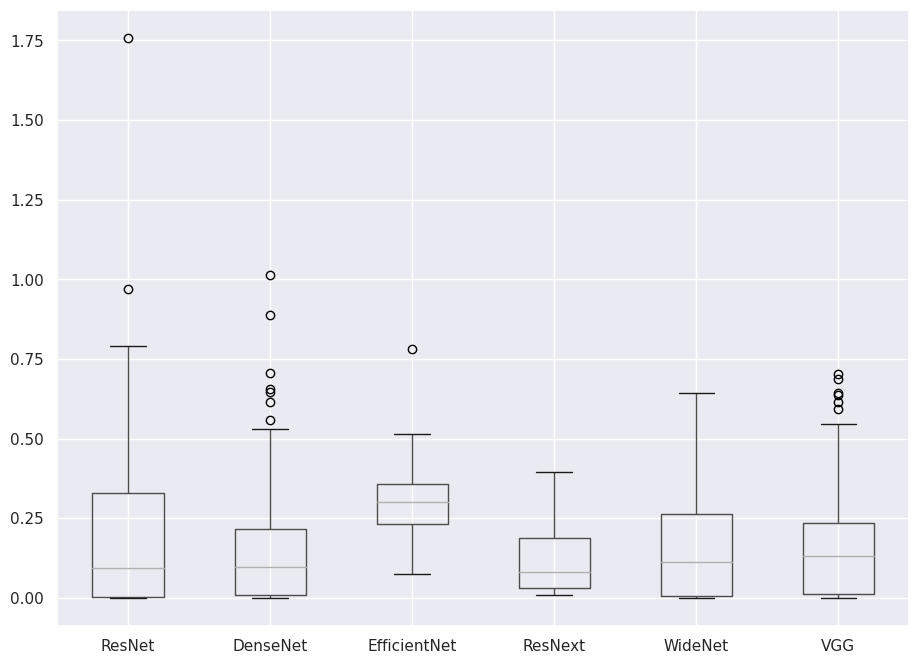

In [53]:
sns.set(rc={'figure.figsize':(11,8)})
loss_df.boxplot()

<AxesSubplot: >

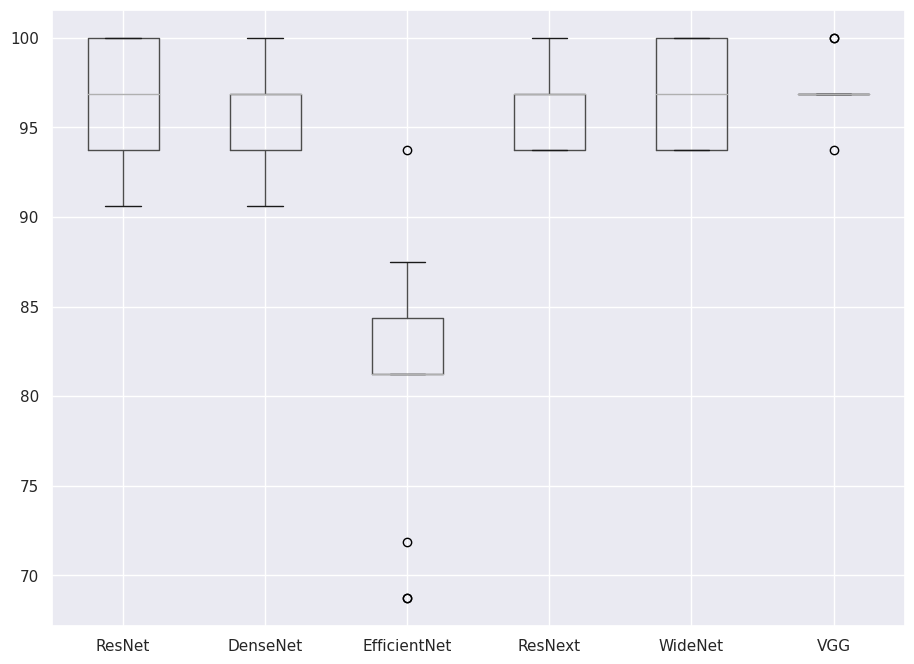

In [54]:
sns.set(rc={'figure.figsize':(11,8)})
acc_df.boxplot()

In [55]:
acc_df.to_csv('./accuracies.csv')

In [56]:
loss_df.to_csv('./losses.csv')

## Comparing all models ##

In [60]:
len(res_net_acc), len(dense_net_acc), len(efficient_net_acc), len(res_next_acc), len(wide_net_acc), len(vgg_acc), len(hybrid_w_resnet_acc), len(hybrid_w_o_resnet_acc)

(13, 13, 13, 13, 13, 13, 133, 133)

In [58]:
loss_data = {'ResNet': res_net_loss, 
             'DenseNet': dense_net_loss, 
             'EfficientNet': efficient_net_loss, 
             'ResNext': res_next_loss, 
             'WideNet': wide_net_loss,
             'VGG' : vgg_loss,
             'hybrid w/ resnet' : hybrid_w_resnet_loss,
             'hybrid w/o resnet' : hybrid_w_o_resnet_loss,
            }

loss_df = pd.DataFrame(data = loss_data)

In [72]:
new_acc = hybrid_w_resnet_acc[-13:].copy()
new_acc1 = hybrid_w_o_resnet_acc[-13:].copy()
for i in range(13):
    new_acc[i] = new_acc[i] * 100.0
    new_acc1[i] = new_acc1[i] * 100.0

In [73]:
acc_data = {'ResNet':  res_net_acc, 
            'DenseNet': dense_net_acc, 
            'EfficientNet': efficient_net_acc, 
            'ResNext': res_next_acc, 
            'WideNet': wide_net_acc,
            'VGG' : vgg_acc,
             'hybrid w/ resnet' : new_acc,
             'hybrid w/o resnet' : new_acc1,
           }
acc_df = pd.DataFrame(data = acc_data)

<AxesSubplot: >

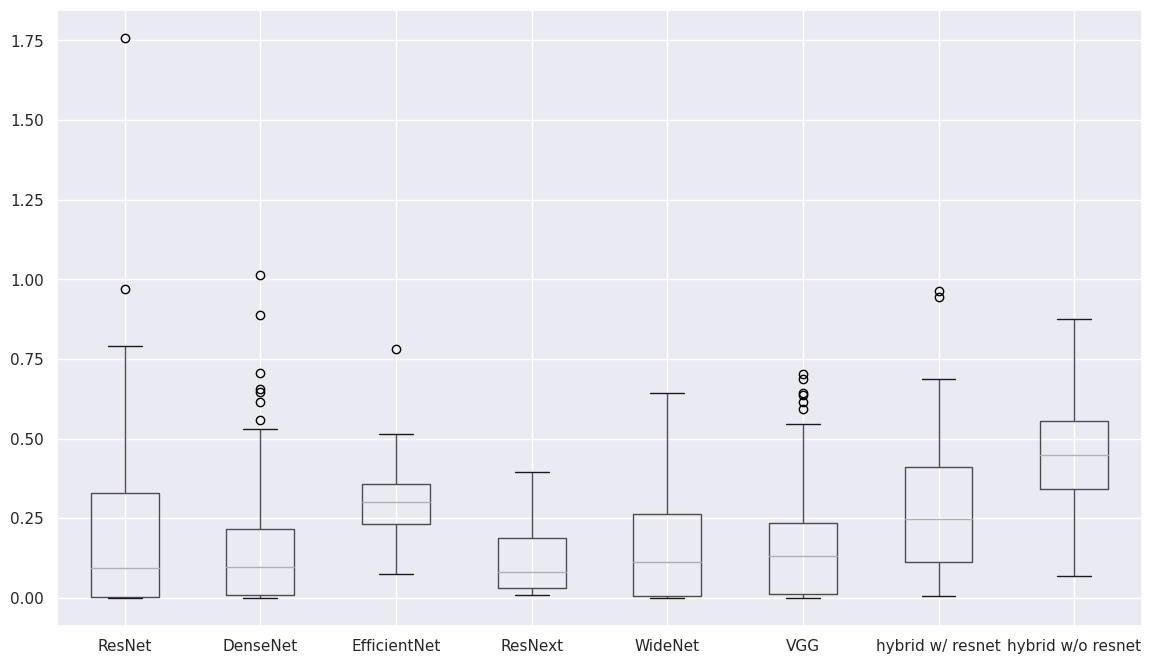

In [67]:
sns.set(rc={'figure.figsize':(14,8)})
loss_df.boxplot()

<AxesSubplot: >

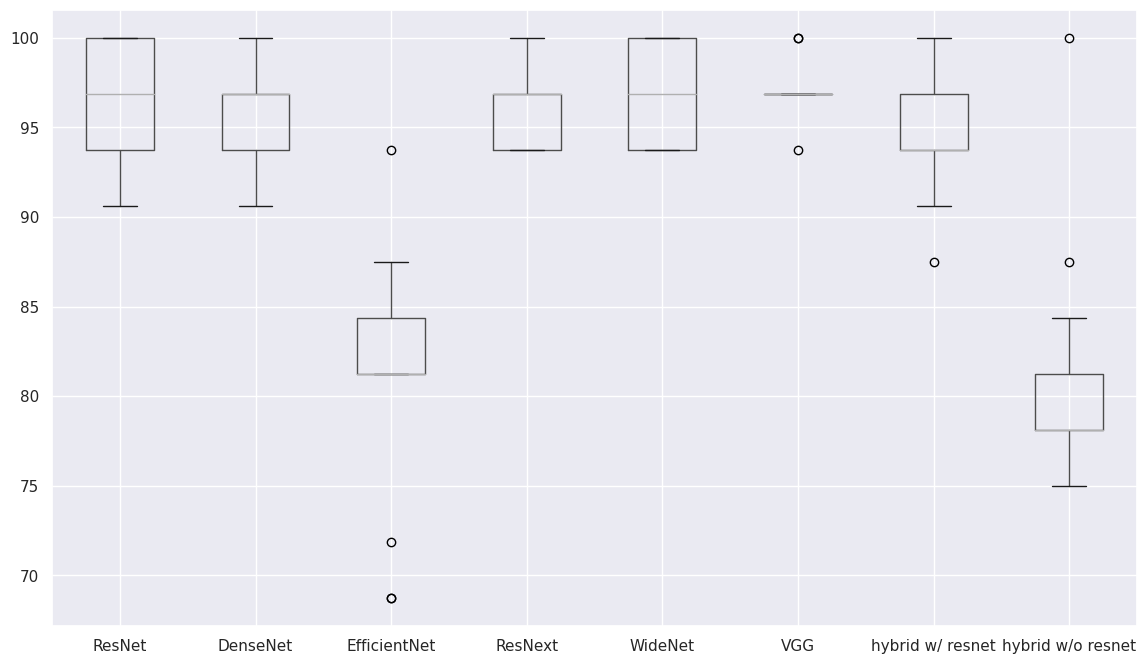

In [74]:
sns.set(rc={'figure.figsize':(14,8)})
acc_df.boxplot()

# Scratch Space #

In [ ]:
def train_model(net, train_data, epochs, l1_weight, l2_weight):
    for epoch in range(epochs):
        for idx, (batch_data, batch_classes, batch_paths) in enumerate(train_data):
           
            preds = net(batch_data.float().to(device))
            
            
            loss = criterion(torch.argmax(preds, 1).float().to(device), batch_classes.float().to(device))
            
            ##Adding Regulartors
            #L1 regularization
            loss = loss + l1_weight * sum([p.abs().sum() for p in net.parameters()])
            
            #L2 regularization
            loss = loss + l2_weight * sum([(p**2).sum() for p in net.parameters()])
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc = (preds.round().to(device) == batch_classes.to(device)).float().mean()
            if idx % 25 == 24:
                print('[%d, %5d] loss : %.6f, accuracy: %.4f' %(epoch + 1, idx + 1, loss.item()/32, acc))
            

In [ ]:
def test_model(net, test_data):
    net.eval()
    correct = 0
    for idx, (batch_data, batch_classes, batch_paths) in enumerate(test_data):
            optimizer.zero_grad()
            preds = net(batch_data.float().to(device))
            
            loss = criterion(torch.argmax(preds, 1).float().to(device), batch_classes.float().to(device))
            
           
            acc = (preds.round().to(device) == batch_classes.to(device)).float().mean()
            if idx % 10 == 9:
                print('loss : %.6f, accuracy: %.4f' %(loss.item()/32, acc))


In [ ]:
epochs = 500
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.BCELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
l1_weight = 0.1
l2_weight = 0.0
train_model(net.to(device), train_data, epochs, l1_weight, l2_weight)

### Testing Hybrid ###

In [ ]:
print('Testing model..')
test_model(model, test_data)

## Using Pytorch Lightning ##

### Efficient Net B0 Version ###

In [ ]:
class Classifier(pl.LightningModule, nn.Module):
    def __init__(self, l1_weight = 0.0, l2_weight = 0.0):
        super(Classifier, self).__init__()
        
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self.t_loss = []
        self.t_acc = []
        
        pre_trained_model = models.efficientnet_b0(weights = True)
        
        self.model = nn.Sequential(
            *list(pre_trained_model.children())[0],
            nn.Flatten(start_dim=1),
            nn.Linear(81920, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )
    
    def training_step(self, batch, batch_idx):
        # print(batch)
        x, y, _ = batch
        y_hat = self.model(x.float().to(device))
        
        y_hat = torch.flatten(y_hat)
        # print(y_hat.shape, y)
        
        loss = F.binary_cross_entropy(y_hat.float(), y.float())
        
        ##Adding Regulartors
        #L1 regularization
        loss = loss + self.l1_weight * sum([p.abs().sum() for p in self.parameters()])

        #L2 regularization
        loss = loss + self.l2_weight * sum([(p**2).sum() for p in self.parameters()])
        
        
        if batch_idx % 50 == 49:
            acc = (y_hat.round().to(device) == y.to(device)).float().mean()
            print('loss : %.6f, accuracy: %.4f' %(loss, acc))
        self.log("train_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):

        x, y, _ = batch
        y_hat = self.model(x.float().to(device))
        
        y_hat = torch.flatten(y_hat)
        # print(y_hat.shape, y)
        
        loss = F.binary_cross_entropy(y_hat.float(), y.float())
        self.t_loss.append(loss.item())
        
        if batch_idx % 10 == 9:
            acc = (y_hat.round().to(device) == y.to(device)).float().mean()
            self.t_acc.append(float(torch.Tensor.cpu(acc) * 100.00))
            print('loss : %.6f, accuracy: %.4f' %(loss, acc))
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay= 1e-2)
        return optimizer

In [ ]:
clf = Classifier(l1_weight = 0.0, l2_weight = 0.0)

In [ ]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model=clf, train_dataloaders=train_data)

In [ ]:
print('Testing model..')
loss = trainer.test(model = clf, dataloaders=test_data)

In [ ]:
efficient_net_loss = clf.t_loss
efficient_net_acc = clf.t_acc

### DenseNet ###

In [ ]:
class Classifier(pl.LightningModule, nn.Module):
    def __init__(self, l1_weight = 0.0, l2_weight = 0.0):
        super(Classifier, self).__init__()
        
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self.t_loss = []
        self.t_acc = []
        
        pre_trained_model = models.densenet121(weights = True)
        
        self.model = nn.Sequential(
            *list(pre_trained_model.children())[0],
            nn.Flatten(start_dim=1),
            nn.Linear(65536, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )
    
    def training_step(self, batch, batch_idx):
        # print(batch)
        x, y, _ = batch
        y_hat = self.model(x.float().to(device))
        
        y_hat = torch.flatten(y_hat)
        # print(y_hat.shape, y)
        
        loss = F.binary_cross_entropy(y_hat.float(), y.float())
        
        ##Adding Regulartors
        #L1 regularization
        loss = loss + self.l1_weight * sum([p.abs().sum() for p in self.parameters()])

        #L2 regularization
        loss = loss + self.l2_weight * sum([(p**2).sum() for p in self.parameters()])
        
        
        if batch_idx % 50 == 49:
            acc = (y_hat.round().to(device) == y.to(device)).float().mean()
            print('loss : %.6f, accuracy: %.4f' %(loss, acc))
        self.log("train_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        t_loss = []
        x, y, _ = batch
        y_hat = self.model(x.float().to(device))
        
        y_hat = torch.flatten(y_hat)
        # print(y_hat.shape, y)
        
        loss = F.binary_cross_entropy(y_hat.float(), y.float())
        self.t_loss.append(loss.item())
        
        if batch_idx % 10 == 9:
            acc = (y_hat.round().to(device) == y.to(device)).float().mean()
            self.t_acc.append(float(torch.Tensor.cpu(acc) * 100.00))
            print('loss : %.6f, accuracy: %.4f' %(loss, acc))
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay = 1e-6)
        return optimizer

In [ ]:
clf = Classifier(l1_weight = 0.000, l2_weight = 0.0)

In [ ]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model=clf, train_dataloaders=train_data)

In [ ]:
print('Testing model..')
trainer.test(model = clf, dataloaders=test_data)

In [ ]:
dense_net_loss = clf.t_loss
dense_net_acc = clf.t_acc

### ResNet ###

In [ ]:
class Classifier(pl.LightningModule, nn.Module):
    def __init__(self, l1_weight = 0.0, l2_weight = 0.0):
        super(Classifier, self).__init__()
        
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self.t_loss = []
        self.t_acc = []
        
        pre_trained_model = models.resnet18(weights = True)
        # print(*list(pre_trained_model.children())[:-2])
        
        self.model = nn.Sequential(
            *list(pre_trained_model.children())[:-2],
            nn.Flatten(start_dim=1),
            nn.Linear(32768, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )
    
    def training_step(self, batch, batch_idx):
        # print(batch)
        x, y, _ = batch
        y_hat = self.model(x.float().to(device))
        
        y_hat = torch.flatten(y_hat)
        # print(y_hat.shape, y)
        
        loss = F.binary_cross_entropy(y_hat.float(), y.float())
        
        ##Adding Regulartors
        #L1 regularization
        loss = loss + self.l1_weight * sum([p.abs().sum() for p in self.parameters()])

        #L2 regularization
        loss = loss + self.l2_weight * sum([(p**2).sum() for p in self.parameters()])
        
        
        if batch_idx % 50 == 49:
            acc = (y_hat.round().to(device) == y.to(device)).float().mean()
            print('loss : %.6f, accuracy: %.4f' %(loss, acc))
        self.log("train_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.model(x.float().to(device))
        
        y_hat = torch.flatten(y_hat)
        # print(y_hat.shape, y)
        
        loss = F.binary_cross_entropy(y_hat.float(), y.float())
        
        self.t_loss.append(loss.item())
        
        if batch_idx % 10 == 9:
            acc = (y_hat.round().to(device) == y.to(device)).float().mean()
            self.t_acc.append(float(torch.Tensor.cpu(acc) * 100.00))
            print('loss : %.6f, accuracy: %.4f' %(loss, acc))
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay = 1e-3)
        return optimizer

In [ ]:
clf = Classifier(l1_weight = 0.0, l2_weight = 0.0)

In [ ]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model=clf, train_dataloaders=train_data)

In [ ]:
print('Testing model..')
trainer.test(model = clf, dataloaders=test_data)

In [ ]:
resnet_loss = clf.t_loss
resnet_acc = clf.t_acc

### ResNext ###

In [ ]:
class Classifier(pl.LightningModule, nn.Module):
    def __init__(self, l1_weight = 0.0, l2_weight = 0.0):
        super(Classifier, self).__init__()
        
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self.t_loss = []
        self.t_acc = []
        
        pre_trained_model = models.resnext50_32x4d(weights = True)
        # print(*list(pre_trained_model.children())[:-1])
        
        self.model = nn.Sequential(
            *list(pre_trained_model.children())[:-1],
            nn.Flatten(start_dim=1),
            nn.Linear(2048, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )
    
    def training_step(self, batch, batch_idx):
        # print(batch)
        x, y, _ = batch
        y_hat = self.model(x.float().to(device))
        
        y_hat = torch.flatten(y_hat)
        # print(y_hat.shape, y)
        
        loss = F.binary_cross_entropy(y_hat.float(), y.float())
        
        ##Adding Regulartors
        #L1 regularization
        loss = loss + self.l1_weight * sum([p.abs().sum() for p in self.parameters()])

        #L2 regularization
        loss = loss + self.l2_weight * sum([(p**2).sum() for p in self.parameters()])
        
        
        if batch_idx % 50 == 49:
            acc = (y_hat.round().to(device) == y.to(device)).float().mean()
            print('loss : %.6f, accuracy: %.4f' %(loss, acc))
        self.log("train_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.model(x.float().to(device))
        
        y_hat = torch.flatten(y_hat)
        # print(y_hat.shape, y)
        
        loss = F.binary_cross_entropy(y_hat.float(), y.float())
        
        self.t_loss.append(loss.item())
        
        if batch_idx % 10 == 9:
            acc = (y_hat.round().to(device) == y.to(device)).float().mean()
            self.t_acc.append(float(torch.Tensor.cpu(acc) * 100.00))
            print('loss : %.6f, accuracy: %.4f' %(loss, acc))
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [ ]:
clf = Classifier(l1_weight = 0.0, l2_weight = 0.0)

In [ ]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model=clf, train_dataloaders=train_data)

In [ ]:
print('Testing model..')
trainer.test(model = clf, dataloaders=test_data)

In [ ]:
resnext_loss = clf.t_loss
resnext_acc = clf.t_acc

### Wide ResNet ###

In [ ]:
class Classifier(pl.LightningModule, nn.Module):
    def __init__(self, l1_weight = 0.0, l2_weight = 0.0):
        super(Classifier, self).__init__()
        
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self.t_loss = []
        self.t_acc = []
        
        pre_trained_model = models.wide_resnet50_2(weights = True)
        # print(*list(pre_trained_model.children())[:-1])
        
        self.model = nn.Sequential(
            *list(pre_trained_model.children())[:-1],
            nn.Flatten(start_dim=1),
            nn.Linear(2048, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )
    
    def training_step(self, batch, batch_idx):
        # print(batch)
        x, y, _ = batch
        y_hat = self.model(x.float().to(device))
        
        y_hat = torch.flatten(y_hat)
        # print(y_hat.shape, y)
        
        loss = F.binary_cross_entropy(y_hat.float(), y.float())
        
        ##Adding Regulartors
        #L1 regularization
        loss = loss + self.l1_weight * sum([p.abs().sum() for p in self.parameters()])

        #L2 regularization
        loss = loss + self.l2_weight * sum([(p**2).sum() for p in self.parameters()])
        
        
        if batch_idx % 50 == 49:
            acc = (y_hat.round().to(device) == y.to(device)).float().mean()
            print('loss : %.6f, accuracy: %.4f' %(loss, acc))
        self.log("train_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.model(x.float().to(device))
        
        y_hat = torch.flatten(y_hat)
        # print(y_hat.shape, y)
        
        loss = F.binary_cross_entropy(y_hat.float(), y.float())
        
        self.t_loss.append(loss.item())
        
        if batch_idx % 10 == 9:
            acc = (y_hat.round().to(device) == y.to(device)).float().mean()
            self.t_acc.append(float(torch.Tensor.cpu(acc) * 100.00))
            print('loss : %.6f, accuracy: %.4f' %(loss, acc))
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [ ]:
clf = Classifier(l1_weight = 0.0, l2_weight = 0.0)

In [ ]:
trainer = pl.Trainer(max_epochs=50)
trainer.fit(model=clf, train_dataloaders=train_data)

In [ ]:
print('Testing model..')
trainer.test(model = clf, dataloaders=test_data)

In [ ]:
widenet_loss = clf.t_loss
widenet_acc = clf.t_acc